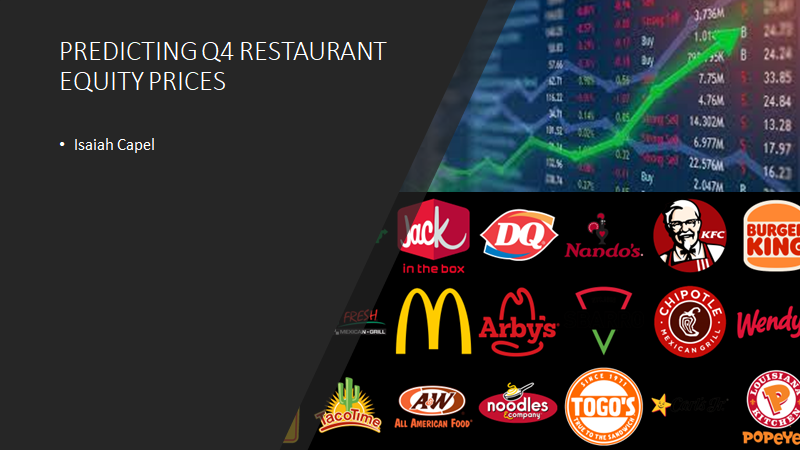

# SUMMARY

This notebook is intended for a hypothetical pension fund looking to cut out the hedge fund or private equity fees by looking to do their own trading. They have asked me to predict which of the top 14 American restaurant stocks will peform best and which will perform worst. 

Of course, examining the restaurant sector without also examining COIVD-19 numbers seems unwise since even 2.5 years in to COVID era, many of these businesses still greatly depend on customers dining at their establishments. Therefore, I used data from the Center for Disease Control(CDC) to predict the COVID numbers for the rest of the year using a Prophet model. Next, I used a Prophet model to predict daily trading volume for each equity. Then, I made an LSTM model of closing prices for all 14 companies over the last 5 years with the exogenous variable of COVID deaths. Then, I made predicitons on that model using the COVID numbers that I predicted. I conlcuded that **Dominos, Papa Johns, and Chipotle perform best while  Wingstop, Cracker Barrel, and Jack in the Box perform worst.**



# BUSINESS UNDERSTANDING

Currently, the market is in a period of uncertainty. Interest rate hikes, supply chain questions, international conflicts, and a still unrelenting but increasingly silent pandemic hover over the marketplace. For any investors looking to save on fees and do their own trading, these problems making profitable trading a daunting task. The restaurant industry, in particular, is vulnerable to so many of those issues. 

My task is to help navigate this perilous industry by providing you with the restaurant industry equities that will perform best in the remainder of this year and the equities that will perform worse. I am using closing price data from Yahoo Finance. Yahoo Finance is an incredibly rich source of finance data. These predictions should refelct the company's preparedness for the current conditions like a COVID surge. I will recommend stock by measuring which has the highest ROI%:



# DATA UNDERSTANDING

To properly model and predict restaurant equity prices in today's world, it's essential to include COVID-19 numbers. There were many "COVID-19 numbers" that I could have used but I decided to use deaths from COVID-19. In another iteration of this work, I may use infection rates but my intuition tells me that people generally worry less about infection nowdays. Basically, increasing infection numbers probably wouldn't alarm consumers but increasing death numbers would deter them from visitng dining establishments in person. 

My COVID-19 death numbers are on a 7 day delay. The reasons are simple: 1:) the CDC takes a week to release results, 2.) the market can take a while to react to COVID numbers. In fact, there is evidence that the market can take very long to react: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8426993/

I used Yahoo Finance site to obtain my price data. I chose to settle on closing price data although intraday price points could be included as well. Each stock in this dataset has, as a prerequisite for examining 5 years of trading, traded for at least 5 years.

**The main metric I use in this notebook is Mean Absolute Percentage Error(MAPE)** because of its universality. I compare between different models and between different stocks. MAPE is great for comparing between very disparate types of values. I will predict prices using multiple models and therefore I need a metric that will provide useful information between models and stocks inside of models. Other metrics like RMSE and MAE would not be helpful in comparing the model's performance on, for example, Chipotle(currently priced in the 4 digits) and Wendy's (trading around 20 dollars). 

# DATA PREPARATION

First things first: I need to import a plethora of libraries and modules:

In [1]:



import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError 
from tensorflow.keras.optimizers import Adam
from numpy.random import seed
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import time
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import itertools
from pmdarima import auto_arima as pm

from pmdarima import model_selection
from numpy import asarray

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

%matplotlib inline
# downloading and opening the excel file with the 5 year data
restaurants = pd. read_excel ("5_year_restaurant_prices.xlsx")
restaurants

Date   McDonalds  Starbucks    Chipotle        Yum  \
0    2017-09-27  154.050003  54.990002  313.850006  73.099998   
1    2017-09-28  157.490005  54.500000  316.529999  73.500000   
2    2017-09-29  156.679993  53.709999  307.829987  73.610001   
3    2017-10-02  156.960007  53.810001  301.809998  73.750000   
4    2017-10-03  156.860001  53.990002  302.989990  73.919998   
...         ...         ...        ...         ...        ...   
1321 2022-12-26         NaN        NaN         NaN        NaN   
1322 2022-12-27         NaN        NaN         NaN        NaN   
1323 2022-12-28         NaN        NaN         NaN        NaN   
1324 2022-12-29         NaN        NaN         NaN        NaN   
1325 2022-12-30         NaN        NaN         NaN        NaN   

      Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
0                 63.869999  79.150002  196.839996   15.58  33.540001   
1                 63.880001  78.959999  197.039993   15.57  33.340000   
2                 63.880001  78.779999  198.550003   15.53  33.250000   
3                 64.269997  79.169998  199.990005   15.29  33.610001   
4                 64.040001  80.110001  202.809998   15.47  33.480000   
...                     ...        ...         ...     ...        ...   
1321                    NaN        NaN         NaN     NaN        NaN   
1322                    NaN        NaN         NaN     NaN        NaN   
1323                    NaN        NaN         NaN     NaN        NaN   
1324                    NaN        NaN         NaN     NaN        NaN   
1325                    NaN        NaN         NaN     NaN        NaN   

      Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  Jack in the Box  
0      74.699997      149.550003    32.580002       17.420000       100.199997  
1      73.660004      150.399994    32.950001       17.510000       101.040001  
2      73.070000      151.619995    33.230000       17.600000       101.919998  
3      72.559998      153.899994    33.389999       17.639999       100.589996  
4      70.610001      153.210007    33.139999       17.170000        99.339996  
...          ...             ...          ...             ...              ...  
1321         NaN             NaN          NaN             NaN              NaN  
1322         NaN             NaN          NaN             NaN              NaN  
1323         NaN             NaN          NaN             NaN              NaN  
1324         NaN             NaN          NaN             NaN              NaN  
1325         NaN             NaN          NaN             NaN              NaN  

[1326 rows x 15 columns]

The null values in the latter part of the DataFrame represent future data points that have not yet come but will be predicted. Next, it's important to set the "Date" column to a datetime when using a time series:

In [2]:
restaurants['Date'] =pd.to_datetime(restaurants['Date'])

Next, "Date" must be made the index:

In [3]:
restaurants.index= restaurants['Date']
restaurants.drop(['Date'],axis=1, inplace=True)

Let's do some exploration and check for stationarity:

In [4]:
def dftest_stationarity(data):
    for x in data:
        # Check to see if the p-value ≤ .05. If so, it returns the the stationary zipcodes with associated values.
        if  adfuller(data[x])[1] <=.05: 
            return(x, adfuller(data[x])[0:6])
        

In [5]:
dftest_stationarity(restaurants.iloc[:1267].fillna(0))

('Restaurant Brands Int',
 (-3.2387994131264457,
  0.017845835632014112,
  12,
  1254,
  {'1%': -3.4355754676859886,
   '5%': -2.8638475772391665,
   '10%': -2.5679985805677017},
  3594.1956707712025))

Only Restaurant Brands Int is stationary.

In [6]:
# Checking for stationarity on log scaled data
restaurants_log=np.log(restaurants.iloc[:1267].fillna(0))
dftest_stationarity(restaurants_log)

('Restaurant Brands Int',
 (-3.57451147226002,
  0.006267432248044325,
  16,
  1250,
  {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776},
  -6259.063295187531))

Again, only Restaurant Brands Int is stationary.

In [7]:
# Checking for stationarity on square root data

restaurants_sqrt = np.sqrt(restaurants.iloc[:1267].fillna(0))
dftest_stationarity(restaurants_sqrt)

('Restaurant Brands Int',
 (-3.460165355062584,
  0.009071043465808885,
  12,
  1254,
  {'1%': -3.4355754676859886,
   '5%': -2.8638475772391665,
   '10%': -2.5679985805677017},
  -3080.094514204029))

Once again, only Restaurant Brands International is stationary.

Next, I will import the death numbers into the DataFrame:

# COVID-19 MODELING

Now, let's take a look at the covid death numbers:

In [8]:
ts = pd.read_excel ("7day delay.xlsx")
# Making column 'ds' into a datetime
ts['ds'] =pd.to_datetime(ts['ds'])
ts

ds    y
0    2020-01-23  0.0
1    2020-01-24  0.0
2    2020-01-25  0.0
3    2020-01-26  0.0
4    2020-01-27  0.0
...         ...  ...
1050 2022-12-26  NaN
1051 2022-12-27  NaN
1052 2022-12-28  NaN
1053 2022-12-29  NaN
1054 2022-12-30  NaN

[1055 rows x 2 columns]

Ok, as you can see, there are no numbers yet for future dates. We will have to predict those.

Let's make a copy of the dataset:

In [9]:

ts_copy=ts.copy(deep=True)

ts_copy['ds'] =pd.to_datetime(ts_copy['ds'])
#ts_copy.index= ts_copy['ds']
#ts_copy.drop(['ds'],axis=1, inplace=True)
ts_copy.index
ts_copy

ds    y
0    2020-01-23  0.0
1    2020-01-24  0.0
2    2020-01-25  0.0
3    2020-01-26  0.0
4    2020-01-27  0.0
...         ...  ...
1050 2022-12-26  NaN
1051 2022-12-27  NaN
1052 2022-12-28  NaN
1053 2022-12-29  NaN
1054 2022-12-30  NaN

[1055 rows x 2 columns]

Let's use the square root of the death numbers:

In [10]:
ts_sqrt=ts.copy(deep=True)
ts_sqrt['y']=np.sqrt(ts_sqrt['y'])
ts_sqrt.iloc[989:]

ds   y
989  2022-10-12 NaN
990  2022-10-13 NaN
991  2022-10-14 NaN
992  2022-10-17 NaN
993  2022-10-18 NaN
...         ...  ..
1050 2022-12-26 NaN
1051 2022-12-27 NaN
1052 2022-12-28 NaN
1053 2022-12-29 NaN
1054 2022-12-30 NaN

[66 rows x 2 columns]

Let's set the index for ts to the 'ds' column because we may have to use this DataFrame later.

In [11]:
ts.set_index('ds', inplace=True)

In [12]:
ts_sqrt

ds    y
0    2020-01-23  0.0
1    2020-01-24  0.0
2    2020-01-25  0.0
3    2020-01-26  0.0
4    2020-01-27  0.0
...         ...  ...
1050 2022-12-26  NaN
1051 2022-12-27  NaN
1052 2022-12-28  NaN
1053 2022-12-29  NaN
1054 2022-12-30  NaN

[1055 rows x 2 columns]

## XGBoost Regressor

The 1st model I will employ for modeling COVID-19 deaths is XGBoost Regressor. This is actually not a specialized time-series model but is known for being extremely effective at solving almost any task. However, in order to use, I must extract features of the data. Therefore, I will extract the day, month, and year from the date column.

In [13]:
ts_sqrt_clone= ts_sqrt.iloc[:989].copy(deep=True)
ts_sqrt_clone
ts_sqrt_clone.set_index('ds', inplace=True)
ts_sqrt_clone

y
ds                   
2020-01-23   0.000000
2020-01-24   0.000000
2020-01-25   0.000000
2020-01-26   0.000000
2020-01-27   0.000000
...               ...
2022-10-05  13.527749
2022-10-06  21.330729
2022-10-07  27.129320
2022-10-10  25.534291
2022-10-11  18.000000

[989 rows x 1 columns]

In [14]:
#Extracting the day, year, and month and making them into columns
ts_sqrt_clone['month'] = ts_sqrt_clone.index.month
ts_sqrt_clone['year'] = ts_sqrt_clone.index.year
ts_sqrt_clone['dayofmonth'] = ts_sqrt_clone.index.day


ts_sqrt_clone

y  month  year  dayofmonth
ds                                            
2020-01-23   0.000000      1  2020          23
2020-01-24   0.000000      1  2020          24
2020-01-25   0.000000      1  2020          25
2020-01-26   0.000000      1  2020          26
2020-01-27   0.000000      1  2020          27
...               ...    ...   ...         ...
2022-10-05  13.527749     10  2022           5
2022-10-06  21.330729     10  2022           6
2022-10-07  27.129320     10  2022           7
2022-10-10  25.534291     10  2022          10
2022-10-11  18.000000     10  2022          11

[989 rows x 4 columns]

In [15]:
# Creating the training set
X_train=ts_sqrt_clone.iloc[:923,1:]
y_train=ts_sqrt_clone.iloc[:923,:1]


In [16]:
y_train

y
ds                   
2020-01-23   0.000000
2020-01-24   0.000000
2020-01-25   0.000000
2020-01-26   0.000000
2020-01-27   0.000000
...               ...
2022-07-29  25.278449
2022-07-30  12.247449
2022-07-31  11.000000
2022-08-01  20.074860
2022-08-02  27.055499

[923 rows x 1 columns]

In [17]:
# A grid search for optimal parameters
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
xgb1 = XGBRegressor(random_state=42)
parameters = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [.03, .07], 
              'max_depth': [5, 6, 8],
              'min_child_weight': [4,7],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 200,500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 10,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[21:05:33] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


-0.36044586302751724
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [18]:
#Fitting on the optimized parameters
model_xgb = XGBRegressor(colsample_bytree= .7, learning_rate=  0.03, max_depth= 6, min_child_weight= 4, subsample= 0.7, n_estimators=100)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=6, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
#Creating a test set
X_test=ts_sqrt_clone.iloc[923:,1:]

y_test=ts_sqrt_clone.iloc[923:,:1]
X_test

month  year  dayofmonth
ds                                 
2022-08-03      8  2022           3
2022-08-04      8  2022           4
2022-08-05      8  2022           5
2022-08-06      8  2022           6
2022-08-07      8  2022           7
...           ...   ...         ...
2022-10-05     10  2022           5
2022-10-06     10  2022           6
2022-10-07     10  2022           7
2022-10-10     10  2022          10
2022-10-11     10  2022          11

[66 rows x 3 columns]

In [20]:
xgb_preds=model_xgb.predict(X_train)
print("Train MAPE: %.3f" % (mean_absolute_percentage_error(y_train**2, xgb_preds**2)))
print("MAE Train: %.3f" % (mean_absolute_error(y_train**2,xgb_preds**2)))


Train MAPE: 22950901971408344.000
MAE Train: 379.043


In [21]:
xgb_preds_test=model_xgb.predict(X_test)
print("MAPE Test: %.3f" %(mean_absolute_percentage_error(y_test**2, xgb_preds_test**2)))
print("MAE test: %.3f" % (mean_absolute_error(y_test**2, xgb_preds_test**2)*100))


MAPE Test: 3.118
MAE test: 55256.299


XGBoost Regressor COVID MAPE: 311.757
XGBoost Regressor COVID MAE: 552.563


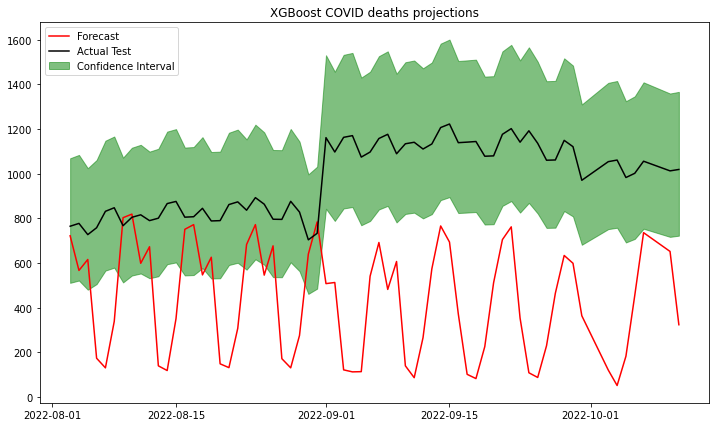

In [22]:
for x in xgb_preds_test:
    interval = 1.96 * xgb_preds_test.std()
    lower, upper = xgb_preds_test - interval, xgb_preds_test + interval
print("XGBoost Regressor COVID MAPE: %.3f" %(mean_absolute_percentage_error(y_test**2, xgb_preds_test**2)*100))
print("XGBoost Regressor COVID MAE: %.3f" %(mean_absolute_error(y_test**2, xgb_preds_test**2)))


plt.figure(figsize=(12,7))
 
plt.plot(ts_sqrt_clone.index[923:], y_test**2, 'r')
plt.plot(ts_sqrt_clone.index[923:], xgb_preds_test**2, 'black')
plt.fill_between(ts_sqrt_clone.index[923:], lower[:66]**2, upper[:66]**2, color="green", alpha=0.5)
plt.legend(['Forecast','Actual Test', 'Confidence Interval'], loc='upper left')
plt.title('XGBoost COVID deaths projections');




Both the MAE and MAPE are very high. Perhaps Prophet will produce better results.

## Prophet

Now let's use Facebook's Prophet to examine the COVID numbers:

In [23]:
ts_sqrt

ds    y
0    2020-01-23  0.0
1    2020-01-24  0.0
2    2020-01-25  0.0
3    2020-01-26  0.0
4    2020-01-27  0.0
...         ...  ...
1050 2022-12-26  NaN
1051 2022-12-27  NaN
1052 2022-12-28  NaN
1053 2022-12-29  NaN
1054 2022-12-30  NaN

[1055 rows x 2 columns]

In [24]:
from prophet import Prophet

covid_model = Prophet(interval_width=0.95)
covid_model.fit(ts_sqrt.iloc[:923])

Importing plotly failed. Interactive plots will not work.
21:05:34 - cmdstanpy - INFO - Chain [1] start processing
21:05:35 - cmdstanpy - INFO - Chain [1] done processing


Let's look at the results on the training and test data:

Prophet COVID MAPE: 42.887
Prophet COVID MAE: 278.998


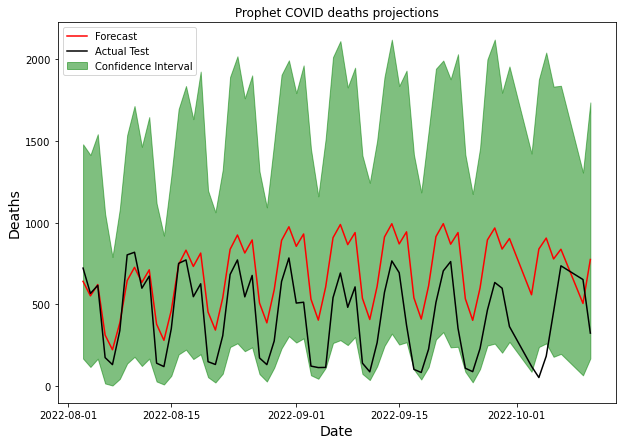

In [25]:
from datetime import datetime
from pandas import DataFrame

from pandas import to_datetime
# Using 66 dates because that is the number of values we need to predict for on the unseen data
future = DataFrame(ts.index[923:989])
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
forecast =  covid_model.predict(future)
# Calculating the MAPE
# Values from DataFrame 'forecast' must be squared to compare with original data

print("Prophet COVID MAPE: %.3f" % (mean_absolute_percentage_error(forecast['yhat']**2,ts.iloc[923:989] )*100))
print("Prophet COVID MAE: %.3f" % (mean_absolute_error(forecast['yhat']**2,ts.iloc[923:989] )))

prophet_covid_mape=mean_absolute_percentage_error(forecast['yhat']**2,ts.iloc[923:989] )*100


# Values from DataFrame 'forecast' must be squared to compare with original data
plt.figure(figsize=(10,7))

plt.plot(ts.index[923:989],forecast['yhat']**2, 'r')
plt.plot(ts.index[923:989], ts.iloc[923:989], 'black')
plt.fill_between(ts.index[923:989], forecast['yhat_upper']**2, forecast['yhat_lower']**2, color="green", alpha=0.5)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Deaths',fontsize=14)
plt.legend(['Forecast','Actual Test', 'Confidence Interval'], loc='upper left')    
plt.title('Prophet COVID deaths projections')

plt.show()


A 43% MAPE is not ideal. The MAE puts the model performance is more concrete terms. A model that is off by 278 deaths daily isn't ideal especially when COVID-19 deaths are declining nationwide. Therefore, it is necessary to employ another model. Therefore, I will try an LSTM model next.

## LSTM COVID MODEL

In [26]:
#Setting the index to 'ds' so the DataFrame can be used in an LSTM
ts_sqrt.set_index('ds', inplace=True)


In order to use an LSTM, I need to make the values of the DataFrame into a tensor. That's the next task:

In [27]:
# Making the DataFrame values into tensors
def create_dataset(X, y, lag=1):
    #Creating a split into an x(dependent variable) and a y(predicted/independent variable)
    xs,ys = [], []
    #For loop to append on each value of the DataFrame
    for i in range(len(X) - lag):
        tmp = X.iloc[i: i+lag].values
        xs.append(tmp)
        ys.append(y.iloc[i+lag])
    
    return np.array(xs), np.array(ys)

In [28]:
training = ts_sqrt.iloc[:913]
training
next_= ts_sqrt.iloc[913:989].fillna(0)
print(training.shape, 'is train shape')

xtrain, ytrain = create_dataset(training, training.iloc[:,0], 10)
xnext, ynext=create_dataset(next_, next_.iloc[:,0],10)

model = Sequential()
model.add(LSTM(76,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2] )))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

model.fit(xtrain, ytrain,
          epochs=10,
          batch_size=10,
          verbose=1,
          shuffle=False
         )

ypred = model.predict(xnext)

ypred = asarray(ypred)
for x in ypred[:]:
    interval = 1.96 * ypred.std()
    lower, upper = ypred - interval, ypred + interval

plt.figure(figsize=(12,7))
#10 values are lost due to lag. 
plt.plot(ts_sqrt.index[913:979], ypred**2, 'r', label="Predictions")
plt.plot(ts_sqrt.index[913:979], next_.iloc[:66,0]**2, 'black', label="Actual")
plt.fill_between(ts_sqrt.index[913:979], lower[:66, 0]**2, upper[:66, 0]**2, color="green", alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.title('LSTM COVID deaths projections')

print("Deaths LSTM MAPE: %.3f" % (mean_absolute_percentage_error(ypred**2, next_.iloc[:66,0]**2)*100))
print("LSTM COVID MAE: %.3f" % (mean_absolute_error(ypred**2, next_.iloc[:66,0]**2)))


(913, 1) is train shape
Epoch 1/10
91/91 [==============================] - 2s 4ms/step - loss: 109.9785
Epoch 2/10
91/91 [==============================] - 0s 5ms/step - loss: 36.9382
Epoch 3/10
91/91 [==============================] - 0s 5ms/step - loss: 39.8567
Epoch 4/10
91/91 [==============================] - 0s 5ms/step - loss: 37.3037
Epoch 5/10
91/91 [==============================] - 0s 5ms/step - loss: 36.5670
Epoch 6/10
91/91 [==============================] - 0s 5ms/step - loss: 37.6682
Epoch 7/10
91/91 [==============================] - 0s 5ms/step - loss: 30.8536
Epoch 8/10
91/91 [==============================] - 0s 5ms/step - loss: 31.5568
Epoch 9/10
91/91 [==============================] - 0s 5ms/step - loss: 33.9693
Epoch 10/10
3/3 [==============================] - 0s 0s/step
Deaths LSTM MAPE: 131.672
LSTM COVID MAE: 307.754


That isn't what I was hoping for. That number is too high. The MAPE remains too high. Even running the model multiple times, I obtain results that are too high. It's probably best to use the Prophet model.

Here's how my predictions compare. Note, the predictions at this website are for 4 weeks intervals. 

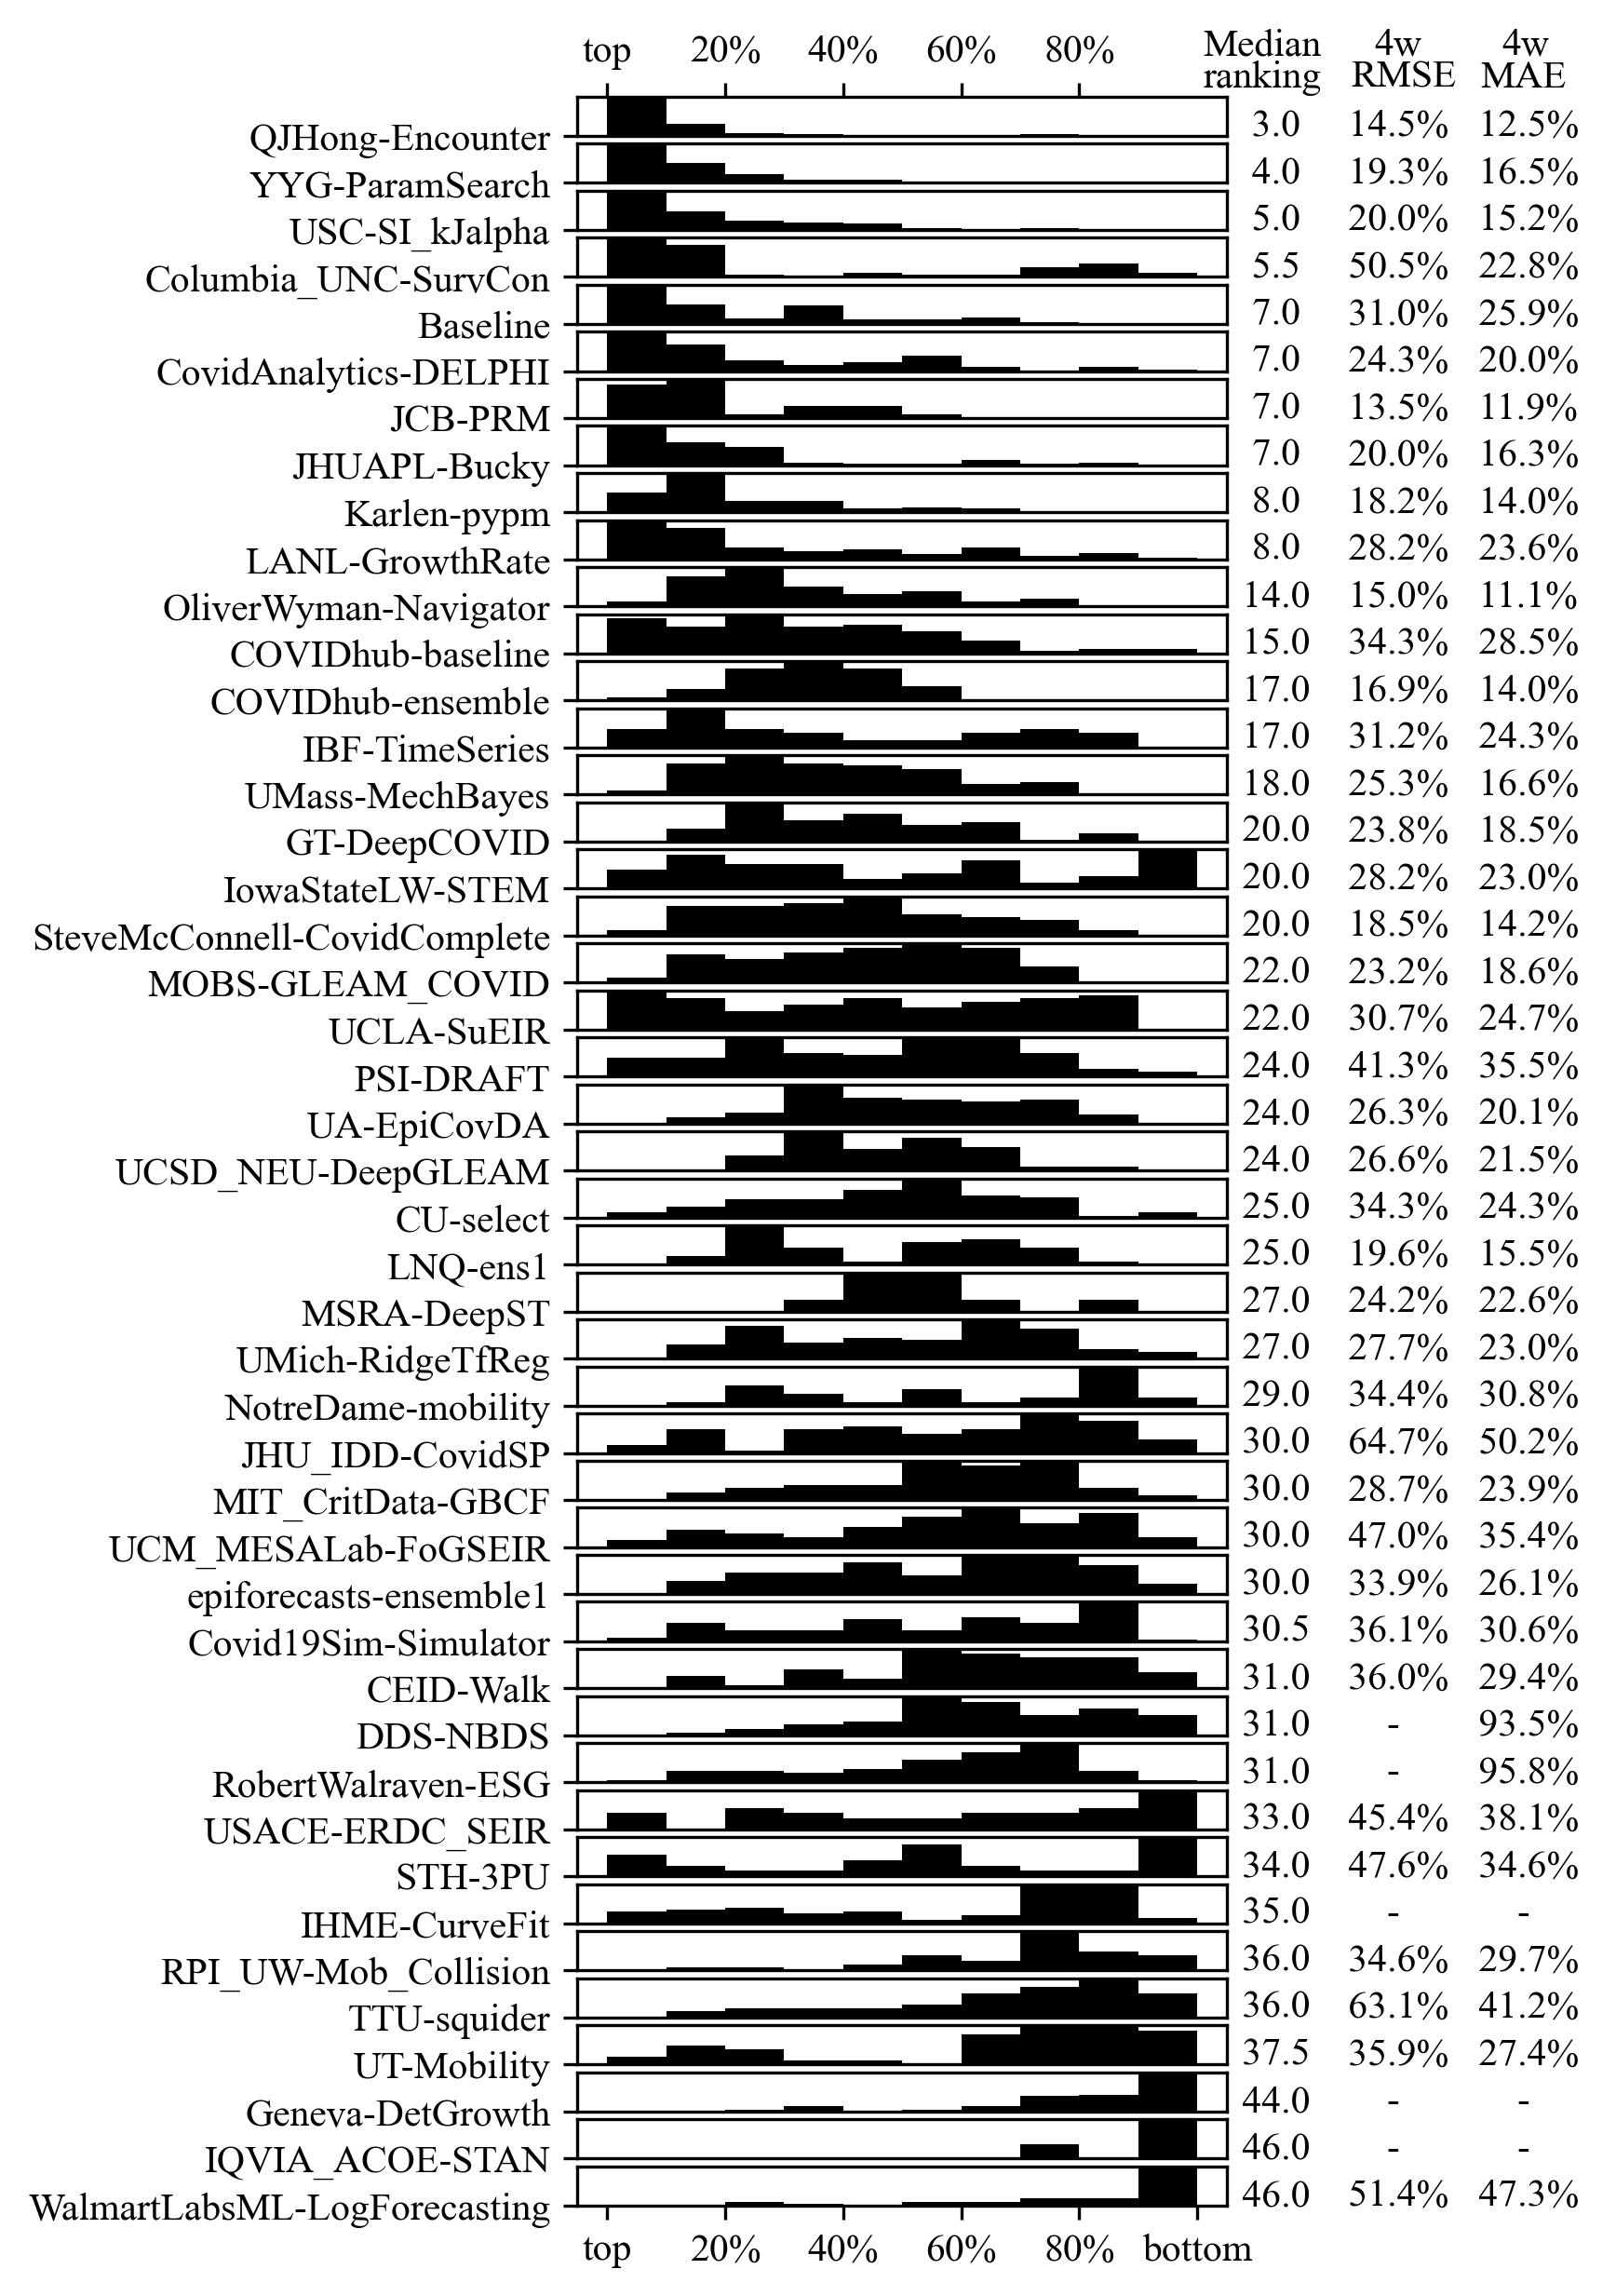

Source:https://qjhong.github.io/

As you can see, my Prophet model is certainly not elite but it also scores beter than some of the other models. Moreover, my model spans 2.5 months while the above models only account for 4 weeks in the future. Therefore, I will use Prophet model since it performed best.

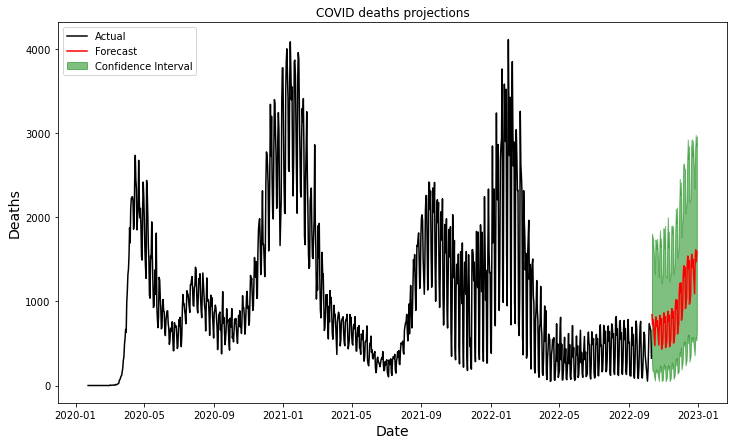

In [29]:
out_of_sample = DataFrame(ts.index[989:1055])
out_of_sample['ds']= to_datetime(out_of_sample['ds'])

predictions=covid_model.predict(out_of_sample)
plt.figure(figsize=(12,7))
plt.plot(ts.index[:989],ts['y'].iloc[:989], 'black')

plt.plot(ts.index[989:1055],predictions['yhat']**2, 'r')
plt.fill_between(ts.index[989:1055], predictions['yhat_upper']**2, predictions['yhat_lower']**2, color="green", alpha=0.5)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Deaths',fontsize=14)
plt.legend(['Actual','Forecast','Confidence Interval'], loc='upper left')    
plt.title('COVID deaths projections')

plt.show()

**OK, now that I have predictions, let's model the Volume**

## Volume

In [30]:
volume = pd. read_excel ("volume.xlsx")
volume['ds'] =pd.to_datetime(volume['ds'])

volume

ds     McDonalds     Starbucks      Chipotle           Yum  \
0    2017-09-27  3.915900e+06  8.671300e+06  1.293000e+06  3.166400e+06   
1    2017-09-28  4.210200e+06  7.607500e+06  6.120000e+05  2.410200e+06   
2    2017-09-29  3.670100e+06  1.194440e+07  1.195800e+06  1.942300e+06   
3    2017-10-02  2.407000e+06  5.956000e+06  1.691400e+06  2.155000e+06   
4    2017-10-03  2.188400e+06  6.137100e+06  8.336000e+05  1.980200e+06   
...         ...           ...           ...           ...           ...   
1321 2022-12-26  2.615291e+06  1.433990e+07  1.048593e+05  1.851928e+06   
1322 2022-12-27  2.619772e+06  1.429493e+07  6.098673e+04  1.838737e+06   
1323 2022-12-28  2.847038e+06  1.506976e+07  3.344814e+04  1.948105e+06   
1324 2022-12-29  2.728289e+06  1.382196e+07 -7.998442e+03  2.465052e+06   
1325 2022-12-30  2.466065e+06  1.330458e+07  7.305260e+03  1.597340e+06   

      Restaurant Brands Int        Darden       Dominos        Wendys  \
0              1.088200e+06  3.086200e+06  5.868000e+05  4.666800e+06   
1              7.079000e+05  2.289300e+06  6.568000e+05  1.741100e+06   
2              1.039400e+06  2.144800e+06  6.363000e+05  1.758500e+06   
3              8.448000e+05  1.535200e+06  1.196900e+06  1.840300e+06   
4              1.013000e+06  1.740700e+06  1.255000e+06  2.369300e+06   
...                     ...           ...           ...           ...   
1321           7.488205e+05  9.008185e+05  1.703727e+05  1.776652e+06   
1322           7.390341e+05  1.000358e+06  2.166956e+05  1.282583e+06   
1323           6.745484e+05  9.782305e+05  1.378586e+05  1.357624e+06   
1324           4.261893e+05  1.734989e+06 -1.949195e+05  2.021969e+06   
1325           7.956080e+05  8.599483e+05  1.600252e+05  1.192946e+06   

           Wingstop     Papa Johns  Cracker Barrel    Shake Shack  \
0     346500.000000  448200.000000   392100.000000  817900.000000   
1     239100.000000  378100.000000   238300.000000  715100.000000   
2     433800.000000  407800.000000   401900.000000  530700.000000   
3     749900.000000  375400.000000   309300.000000  440700.000000   
4     420400.000000  821500.000000   213600.000000  419600.000000   
...             ...            ...             ...            ...   
1321  541714.335136  462747.267095   324170.544925  675099.102624   
1322  514815.351659  306900.261346   284005.153904  674557.163487   
1323  583331.129013  310455.352494   297907.509905  715069.081547   
1324  385588.912680   43502.581107   342752.626192  634945.305028   
1325  514102.181195  237833.936293   256105.279043  557557.354642   

      Bloomin Brands  Jack in the Box  
0       1.199300e+06     4.353000e+05  
1       7.286000e+05     4.948000e+05  
2       8.496000e+05     1.006200e+06  
3       5.912000e+05     4.426000e+05  
4       1.236200e+06     4.925000e+05  
...              ...              ...  
1321    1.823649e+06     3.752781e+05  
1322    1.761315e+06     4.157111e+05  
1323    1.926319e+06     3.426320e+05  
1324    1.659927e+06     1.542672e+05  
1325    1.666351e+06     2.735164e+05  

[1326 rows x 15 columns]

In [31]:
1327-120# Let's use the 1st 60 [1207:1267] as test days and the next 60 are our prediction days

1207

Therefore, we need 60 test days.

21:05:43 - cmdstanpy - INFO - Chain [1] start processing
21:05:44 - cmdstanpy - INFO - Chain [1] done processing
21:05:44 - cmdstanpy - INFO - Chain [1] start processing


Prophet Volume MAPE: 24.575
Prophet Volume MAE: 507627.920


21:05:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet Volume MAPE: 34.810
Prophet Volume MAE: 3706251.827


21:05:45 - cmdstanpy - INFO - Chain [1] start processing
21:05:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet Volume MAPE: 563.479
Prophet Volume MAE: 150259.632


21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing
21:05:47 - cmdstanpy - INFO - Chain [1] start processing


Prophet Volume MAPE: 30.739
Prophet Volume MAE: 447382.451


21:05:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet Volume MAPE: 44.728
Prophet Volume MAE: 444731.489


21:05:48 - cmdstanpy - INFO - Chain [1] start processing
21:05:48 - cmdstanpy - INFO - Chain [1] done processing
21:05:49 - cmdstanpy - INFO - Chain [1] start processing


Prophet Volume MAPE: 60.838
Prophet Volume MAE: 422156.233


21:05:49 - cmdstanpy - INFO - Chain [1] done processing
21:05:50 - cmdstanpy - INFO - Chain [1] start processing


Prophet Volume MAPE: 470.560
Prophet Volume MAE: 530081.782


21:05:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet Volume MAPE: 43.254
Prophet Volume MAE: 891171.578


21:05:50 - cmdstanpy - INFO - Chain [1] start processing
21:05:51 - cmdstanpy - INFO - Chain [1] done processing
21:05:51 - cmdstanpy - INFO - Chain [1] start processing


Prophet Volume MAPE: 70.348
Prophet Volume MAE: 312058.451


21:05:52 - cmdstanpy - INFO - Chain [1] done processing
21:05:52 - cmdstanpy - INFO - Chain [1] start processing


Prophet Volume MAPE: 52.612
Prophet Volume MAE: 209612.844


21:05:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet Volume MAPE: 55.002
Prophet Volume MAE: 145844.210


21:05:53 - cmdstanpy - INFO - Chain [1] start processing
21:05:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet Volume MAPE: 29.308
Prophet Volume MAE: 216113.858


21:05:54 - cmdstanpy - INFO - Chain [1] start processing
21:05:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet Volume MAPE: 35.025
Prophet Volume MAE: 678417.312


21:05:55 - cmdstanpy - INFO - Chain [1] start processing
21:05:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet Volume MAPE: 147.450
Prophet Volume MAE: 206478.346


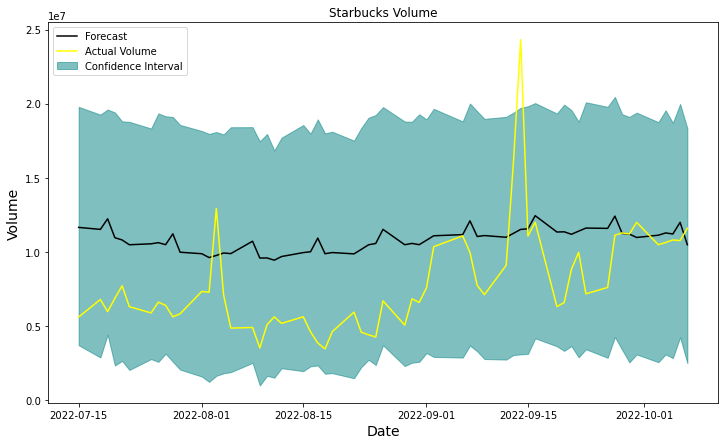

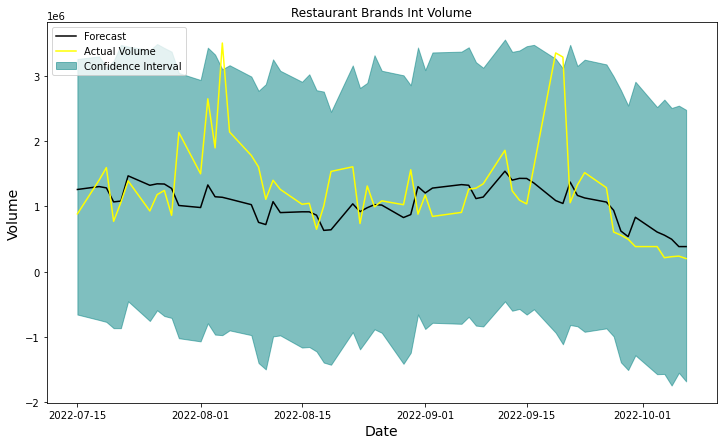

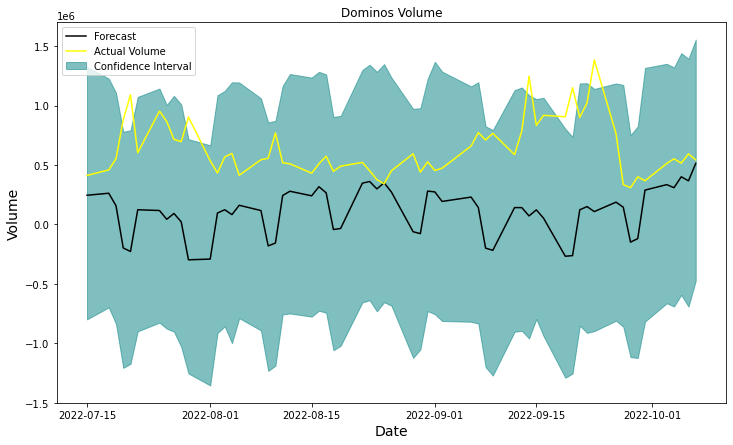

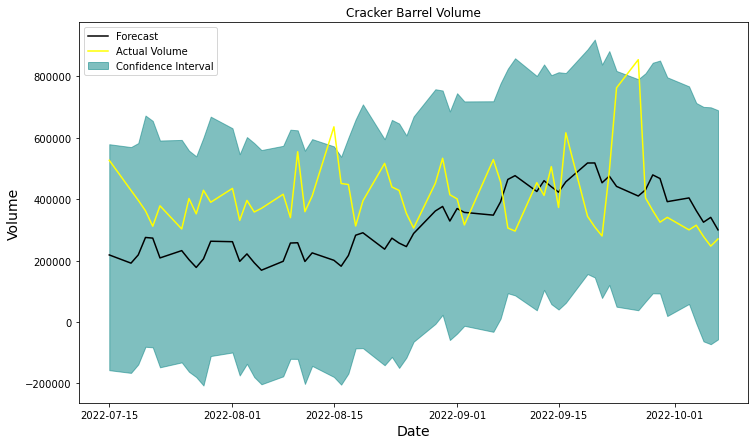

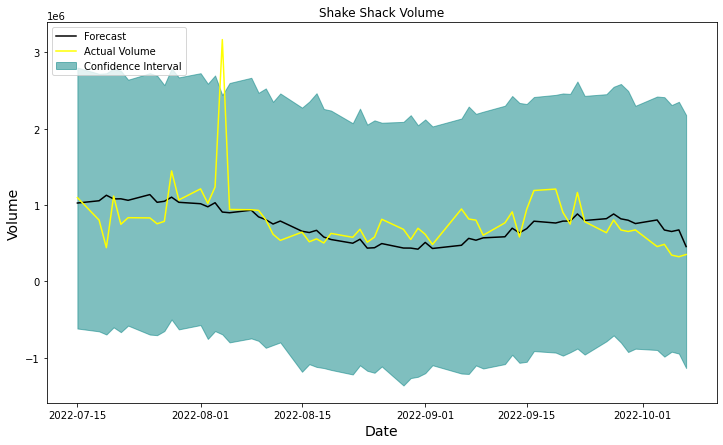

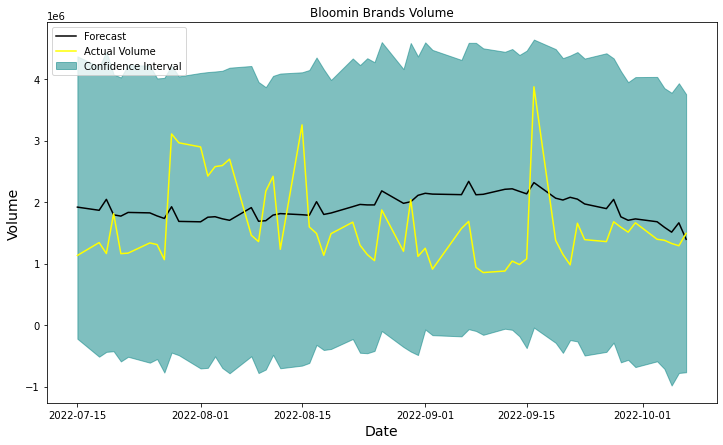

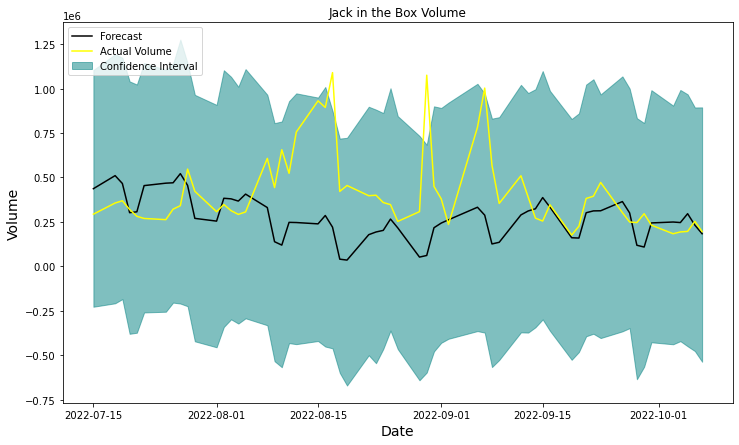

In [32]:

volume_copy=volume.copy(deep=True)
volume_copy.set_index('ds', inplace=True)
#Log transforming volume numbers
volume_copy=np.log(volume_copy)
past_vol=volume.iloc[:, 1:]
prophet_volume=dict()
future_volume=dict()

for x in past_vol:
    series= past_vol[x]
    vol_ds=volume['ds'].iloc[:1207]
    volume_num=pd.concat([vol_ds, series], axis=1)
    volume_num.rename(columns={ series.name:"y"}, inplace=True)
    volume_num['ds'] =pd.to_datetime( volume_num['ds'])

    volume_model = Prophet(interval_width=0.95)
    volume_model.fit(volume_num.iloc[:1181])
    future_vol = DataFrame(volume_copy.index[1207:1267])
    future_vol.columns = ['ds']
    future_vol['ds']= to_datetime(future['ds'])
    forecast =  volume_model.predict(future_vol)
    # Calculating the MAPE

    print("Prophet Volume MAPE: %.3f" % (mean_absolute_percentage_error(forecast['yhat'],volume_num['y'].iloc[1207:1267] )*100))
    print("Prophet Volume MAE: %.3f" % (mean_absolute_error(forecast['yhat'],volume_num['y'].iloc[1207:1267] )))

    prophet_volume[x]=mean_absolute_percentage_error(forecast['yhat'],volume_num['y'].iloc[1207:1267] )*100

    plt.figure(figsize=(12,7))

    plt.plot(volume_copy.index[1207:1267],forecast['yhat'], 'black')
    plt.plot(volume_copy.index[1207:1267], volume_num['y'].iloc[1207:1267], 'yellow')
    plt.fill_between(volume_copy.index[1207:1267], forecast['yhat_upper'], forecast['yhat_lower'], color="teal", alpha=0.5)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Volume',fontsize=14)
    plt.legend(['Forecast','Actual Volume', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{x} Volume')
    # For out of sample predictions
    #out_of_sample_1 = DataFrame(volume_copy.index[1258:])
    #out_of_sample_1['ds']= to_datetime(out_of_sample_1['ds'])


    #predictions_1=volume_model.predict(out_of_sample_1)
    #future_volume[x]=predictions_1['yhat']
    
    #plt.figure(figsize=(12,7))

    #plt.plot(volume.index[1258:],predictions_1['yhat'], 'red')
    #plt.fill_between(volume.index[1258:], predictions_1['yhat_upper'], predictions_1['yhat_lower'], color="black", alpha=0.5)
    #plt.xlabel('Date',fontsize=14)
    #plt.ylabel('Deaths',fontsize=14)
    #plt.legend(['Forecast','Confidence Interval'], loc='upper left')    
    #plt.title(f'{x} Future Volume')
    #plt.show()

    


In [33]:
from operator import itemgetter, attrgetter
prop_vol_errors= sorted(prophet_volume.items(), key=itemgetter(0), reverse=True)
prop_vol_mapes= pd.DataFrame(prop_vol_errors)
prop_vol_mapes.rename( columns={0 :'Stock', 1:'Prophet Volume MAPEs'}, inplace=True )
prop_vol_mapes

Stock  Prophet Volume MAPEs
0                     Yum             30.738558
1                Wingstop             70.347978
2                  Wendys             43.254390
3               Starbucks             34.810300
4             Shake Shack             29.307992
5   Restaurant Brands Int             44.728348
6              Papa Johns             52.611679
7               McDonalds             24.574718
8         Jack in the Box            147.450034
9                 Dominos            470.559621
10                 Darden             60.838279
11         Cracker Barrel             55.002337
12               Chipotle            563.479242
13         Bloomin Brands             35.025125

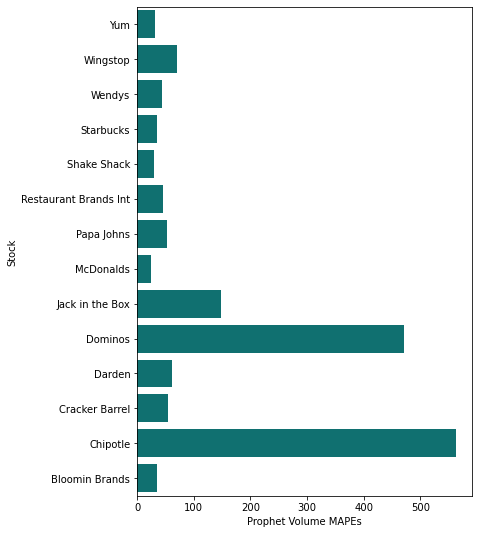

In [34]:
f, ax = plt.subplots(figsize=(6, 9))
sns.barplot(x='Prophet Volume MAPEs',y='Stock', data=prop_vol_mapes, color="teal");

In [35]:
preds=dict()
mapes_lstm_vol=dict()
for x in volume_copy:

    training =  volume_copy.iloc[:1198].fillna(0)
    next_=  volume_copy.iloc[1198:1265].fillna(0)
    future_vol=volume_copy.iloc[1265:1327].fillna(0)

    xtrain, ytrain = create_dataset(training, training.iloc[:,0], 2)
    xnext, ynext=create_dataset(next_, next_.iloc[:,0],2)
    xfuture_vol, yfuture_vol=create_dataset(future_vol, future_vol.iloc[:,0],2)
    model = Sequential()
    model.add(LSTM(70,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2] )))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")

    model.fit(xtrain, ytrain,epochs=10,batch_size=10, verbose=1,shuffle=False)

    ypred_vol= model.predict(xnext)
    #Predicting for future values. LSTM is a stochastic process so results will vary each time.
    future_vol_pred=model.predict(xfuture_vol)

    vol_series = pd.Series(future_vol_pred[:,0])
    vol_series
    preds[x]=vol_series
    #for x in ypred_vol[:]:
        #interval = 1.96 * ypred_vol.std()
        #lower, upper = ypred_vol - interval, ypred_vol + interval
    

    #plt.figure(figsize=(12,7))
    #10 values are lost due to lag. 
    #plt.plot(volume.index[1240:], np.e**ypred_vol, 'r', label="Predictions")
    #plt.plot(volume.index[1240:], np.e**next_.iloc[:62,0], 'black', label="Actual")
    #plt.fill_between(volume.index[1240:1302], np.e**lower[:62, 0]**2, np.e**upper[:62, 0]**2, color="green", alpha=0.5)
    #plt.xlabel("Date")
    ##plt.ylabel("Volume") 
    #plt.title('LSTM Volume')

    print(x, 'Volume MAPE', (mean_absolute_percentage_error(ypred_vol,next_.iloc[:65,0])*100))
    print(x,  'Volume MAE', (mean_absolute_error(ypred_vol, next_.iloc[:65,0])))
    mapes_lstm_vol[x]=mean_absolute_percentage_error(ypred_vol,next_.iloc[:65,0])*100

Epoch 1/10
120/120 [==============================] - 2s 2ms/step - loss: 11.2491
Epoch 2/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1572
Epoch 3/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1620
Epoch 4/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1686
Epoch 5/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1683
Epoch 6/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1591
Epoch 7/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1496
Epoch 8/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1459
Epoch 9/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1460
Epoch 10/10
2/2 [==============================] - 0s 16ms/step
McDonalds Volume MAPE 3.6370385981078974
McDonalds Volume MAE 0.48462210264086475
Epoch 1/10
120/120 [==============================] - 2s 3ms/step - loss: 16.3733
Epoch 2/10
120/120 [======================

120/120 [==============================] - 0s 2ms/step - loss: 0.1998
Epoch 5/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1880
Epoch 6/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1756
Epoch 7/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1685
Epoch 8/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1646
Epoch 9/10
120/120 [==============================] - 0s 2ms/step - loss: 0.1623
Epoch 10/10
2/2 [==============================] - 0s 0s/step
Wingstop Volume MAPE 2.2772231067213426
Wingstop Volume MAE 0.31442007396714045
Epoch 1/10
120/120 [==============================] - 2s 2ms/step - loss: 3.1317
Epoch 2/10
120/120 [==============================] - 0s 2ms/step - loss: 0.2565
Epoch 3/10
120/120 [==============================] - 0s 2ms/step - loss: 0.2408
Epoch 4/10
120/120 [==============================] - 0s 2ms/step - loss: 0.2299
Epoch 5/10
120/120 [==============================] - 0s 2m

In [36]:
from operator import itemgetter, attrgetter
lstm_vol_errors= sorted(mapes_lstm_vol.items(), key=itemgetter(0), reverse=True)
lstm_vol_mapes= pd.DataFrame(lstm_vol_errors)
lstm_vol_mapes.rename( columns={0 :'Stock', 1:'LSTM Volume MAPEs'}, inplace=True )
lstm_vol_mapes

Stock  LSTM Volume MAPEs
0                     Yum           2.970052
1                Wingstop           2.277223
2                  Wendys           2.761928
3               Starbucks           1.199543
4             Shake Shack           2.423123
5   Restaurant Brands Int           2.328928
6              Papa Johns           2.931533
7               McDonalds           3.637039
8         Jack in the Box           1.495418
9                 Dominos           4.235841
10                 Darden           1.955252
11         Cracker Barrel           2.290614
12               Chipotle           1.601393
13         Bloomin Brands           1.314786

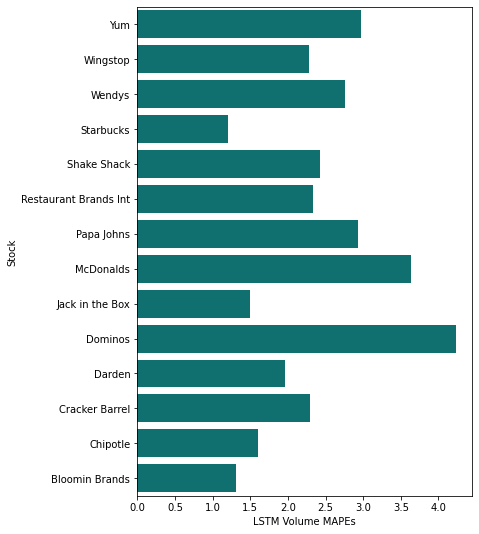

In [37]:
f, ax = plt.subplots(figsize=(6, 9))
sns.barplot(x='LSTM Volume MAPEs',y='Stock', data=lstm_vol_mapes, color="teal");

In [38]:
preds_vol=pd.DataFrame.from_dict(preds)


Making both the predictions and the 'volume_copy' into Excel. The results in the preds_vol.xlsx were from a previous LSTM but again LSTM is stochastic and will produce different results every time.

In [39]:
#Making DataFrame into Excel
#preds_vol.to_excel("preds_vol.xlsx")
#volume_copy.to_excel("volume_copy.xlsx")


In [40]:
vol_full = pd. read_excel ("volume_copy.xlsx")
vol_full

ds  McDonalds  Starbucks   Chipotle        Yum  \
0    2017-09-27  15.180556  15.975529  14.072476  14.968106   
1    2017-09-28  15.253021  15.844645  13.324488  14.695220   
2    2017-09-29  15.115729  16.295773  13.994326  14.479383   
3    2017-10-02  14.693892  15.599910  14.341067  14.583301   
4    2017-10-03  14.598681  15.629863  13.633509  14.498708   
...         ...        ...        ...        ...        ...   
1321 2022-12-26  14.527125  14.007763  14.476140  14.301470   
1322 2022-12-27  14.459140  14.004930  14.463622  14.341323   
1323 2022-12-28  14.422832  14.058701  14.502076  14.292338   
1324 2022-12-29  14.391884  13.967605  14.452594  14.264028   
1325 2022-12-30  12.259944  12.483760  13.172584  12.872328   

      Restaurant Brands Int     Darden    Dominos     Wendys   Wingstop  \
0                 13.900036  14.942451  13.282439  15.355984  12.755638   
1                 13.470058  14.643757  13.395135  14.370028  12.384637   
2                 13.854154  14.578557  13.363425  14.379972  12.980339   
3                 13.646855  14.244171  13.995245  14.425439  13.527695   
4                 13.828427  14.369798  14.042646  14.678105  12.948962   
...                     ...        ...        ...        ...        ...   
1321              14.250830  14.404818  14.283086  14.358101  14.099237   
1322              14.332242  14.411596  14.306379  14.389453  14.167661   
1323              14.322409  14.449010  14.287581  14.331547  14.200298   
1324              14.219143  14.363514  14.188259  14.254416  14.022746   
1325              12.808302  13.209122  12.333591  11.550920  11.145642   

      Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  Jack in the Box  
0      13.012995       12.879272    13.614495       13.997249        12.983791  
1      12.842914       12.381286    13.480178       13.498880        13.111909  
2      12.918532       12.903959    13.181952       13.652521        13.821691  
3      12.835747       12.642067    12.996120       13.289910        13.000422  
4      13.618887       12.271860    12.947057       14.027553        13.107250  
...          ...             ...          ...             ...              ...  
1321   14.393188       14.581648    14.151305       14.329449        14.008760  
1322   14.365440       14.598057    14.140480       14.336628        13.992701  
1323   14.433408       14.569805    14.103364       14.309126        13.976744  
1324   14.357587       14.585541    14.064636       14.250428        13.898216  
1325   14.150422       14.468459    13.162843       12.261642        12.256399  

[1326 rows x 15 columns]

Ok, I saved the results and put it in an Excel file. I'll use the results later.

# PRICE MODELING

## Auto-Arima

The 1st model I will employ is an Auto-Arima model.

Let's merge the price data with the death data:

In [41]:
# Merge on restaurants index.
merged=restaurants.merge(ts, how='left',left_on=restaurants.index, right_on=ts.index)
#Filling any null with 0.
merged['y'].fillna(0, inplace=True)
#Renaming the "y" column in ts_copy with deaths
merged.rename(columns={"y": "deaths", "key_0":"Dates"}, inplace=True)
merged.set_index('Dates', inplace=True)
merged

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26         NaN        NaN         NaN        NaN   
2022-12-27         NaN        NaN         NaN        NaN   
2022-12-28         NaN        NaN         NaN        NaN   
2022-12-29         NaN        NaN         NaN        NaN   
2022-12-30         NaN        NaN         NaN        NaN   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26                    NaN        NaN         NaN     NaN        NaN   
2022-12-27                    NaN        NaN         NaN     NaN        NaN   
2022-12-28                    NaN        NaN         NaN     NaN        NaN   
2022-12-29                    NaN        NaN         NaN     NaN        NaN   
2022-12-30                    NaN        NaN         NaN     NaN        NaN   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26         NaN             NaN          NaN             NaN   
2022-12-27         NaN             NaN          NaN             NaN   
2022-12-28         NaN             NaN          NaN             NaN   
2022-12-29         NaN             NaN          NaN             NaN   
2022-12-30         NaN             NaN          NaN             NaN   

            Jack in the Box  deaths  
Dates                                
2017-09-27       100.199997     0.0  
2017-09-28       101.040001     0.0  
2017-09-29       101.919998     0.0  
2017-10-02       100.589996     0.0  
2017-10-03        99.339996     0.0  
...                     ...     ...  
2022-12-26              NaN     0.0  
2022-12-27              NaN     0.0  
2022-12-28              NaN     0.0  
2022-12-29              NaN     0.0  
2022-12-30              NaN     0.0  

[1326 rows x 15 columns]

Making a copy and setting its index to 'Dates':

In [42]:
merged_copy=merged.copy(deep=True)
#merged_copy.set_index('Dates', inplace=True)
merged_copy

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26         NaN        NaN         NaN        NaN   
2022-12-27         NaN        NaN         NaN        NaN   
2022-12-28         NaN        NaN         NaN        NaN   
2022-12-29         NaN        NaN         NaN        NaN   
2022-12-30         NaN        NaN         NaN        NaN   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26                    NaN        NaN         NaN     NaN        NaN   
2022-12-27                    NaN        NaN         NaN     NaN        NaN   
2022-12-28                    NaN        NaN         NaN     NaN        NaN   
2022-12-29                    NaN        NaN         NaN     NaN        NaN   
2022-12-30                    NaN        NaN         NaN     NaN        NaN   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26         NaN             NaN          NaN             NaN   
2022-12-27         NaN             NaN          NaN             NaN   
2022-12-28         NaN             NaN          NaN             NaN   
2022-12-29         NaN             NaN          NaN             NaN   
2022-12-30         NaN             NaN          NaN             NaN   

            Jack in the Box  deaths  
Dates                                
2017-09-27       100.199997     0.0  
2017-09-28       101.040001     0.0  
2017-09-29       101.919998     0.0  
2017-10-02       100.589996     0.0  
2017-10-03        99.339996     0.0  
...                     ...     ...  
2022-12-26              NaN     0.0  
2022-12-27              NaN     0.0  
2022-12-28              NaN     0.0  
2022-12-29              NaN     0.0  
2022-12-30              NaN     0.0  

[1326 rows x 15 columns]

In [43]:
# A Dataframe with no future values
merged_insample=merged.iloc[:1267,:]
#merged_insample.set_index('Dates', inplace=True)
merged_insample.asfreq('d').index
merged_insample

McDonalds  Starbucks     Chipotle         Yum  \
Dates                                                        
2017-09-27  154.050003  54.990002   313.850006   73.099998   
2017-09-28  157.490005  54.500000   316.529999   73.500000   
2017-09-29  156.679993  53.709999   307.829987   73.610001   
2017-10-02  156.960007  53.810001   301.809998   73.750000   
2017-10-03  156.860001  53.990002   302.989990   73.919998   
...                ...        ...          ...         ...   
2022-10-03  235.340000  85.620000  1468.160000  109.110000   
2022-10-04  238.500000  88.510000  1524.200000  111.410000   
2022-10-05  239.090000  90.120000  1495.860000  112.330000   
2022-10-06  234.750000  89.350000  1506.010000  110.120000   
2022-10-07  233.190000  87.030000  1465.310000  108.930000   

            Restaurant Brands Int      Darden     Dominos  Wendys    Wingstop  \
Dates                                                                           
2017-09-27              63.869999   79.150002  196.839996   15.58   33.540001   
2017-09-28              63.880001   78.959999  197.039993   15.57   33.340000   
2017-09-29              63.880001   78.779999  198.550003   15.53   33.250000   
2017-10-02              64.269997   79.169998  199.990005   15.29   33.610001   
2017-10-03              64.040001   80.110001  202.809998   15.47   33.480000   
...                           ...         ...         ...     ...         ...   
2022-10-03              54.110000  125.410000  316.440000   18.95  123.030000   
2022-10-04              55.480000  132.220000  330.610000   19.47  128.760000   
2022-10-05              55.130000  133.100000  335.130000   19.56  137.650000   
2022-10-06              53.580000  129.510000  324.220000   19.54  133.040000   
2022-10-07              52.310000  125.690000  314.520000   19.10  128.320000   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-10-03   73.450000       91.410000    45.630000       18.440000   
2022-10-04   75.560000       97.150000    46.560000       19.600000   
2022-10-05   74.430000       96.450000    46.460000       19.890000   
2022-10-06   71.810000       95.010000    47.840000       19.680000   
2022-10-07   68.680000       91.450000    46.690000       19.360000   

            Jack in the Box  deaths  
Dates                                
2017-09-27       100.199997     0.0  
2017-09-28       101.040001     0.0  
2017-09-29       101.919998     0.0  
2017-10-02       100.589996     0.0  
2017-10-03        99.339996     0.0  
...                     ...     ...  
2022-10-03        72.630000   121.0  
2022-10-04        77.130000    52.0  
2022-10-05        77.700000   183.0  
2022-10-06        75.400000   455.0  
2022-10-07        74.750000   736.0  

[1267 rows x 15 columns]

In [44]:
vol_full.fillna(method='bfill')

ds  McDonalds  Starbucks   Chipotle        Yum  \
0    2017-09-27  15.180556  15.975529  14.072476  14.968106   
1    2017-09-28  15.253021  15.844645  13.324488  14.695220   
2    2017-09-29  15.115729  16.295773  13.994326  14.479383   
3    2017-10-02  14.693892  15.599910  14.341067  14.583301   
4    2017-10-03  14.598681  15.629863  13.633509  14.498708   
...         ...        ...        ...        ...        ...   
1321 2022-12-26  14.527125  14.007763  14.476140  14.301470   
1322 2022-12-27  14.459140  14.004930  14.463622  14.341323   
1323 2022-12-28  14.422832  14.058701  14.502076  14.292338   
1324 2022-12-29  14.391884  13.967605  14.452594  14.264028   
1325 2022-12-30  12.259944  12.483760  13.172584  12.872328   

      Restaurant Brands Int     Darden    Dominos     Wendys   Wingstop  \
0                 13.900036  14.942451  13.282439  15.355984  12.755638   
1                 13.470058  14.643757  13.395135  14.370028  12.384637   
2                 13.854154  14.578557  13.363425  14.379972  12.980339   
3                 13.646855  14.244171  13.995245  14.425439  13.527695   
4                 13.828427  14.369798  14.042646  14.678105  12.948962   
...                     ...        ...        ...        ...        ...   
1321              14.250830  14.404818  14.283086  14.358101  14.099237   
1322              14.332242  14.411596  14.306379  14.389453  14.167661   
1323              14.322409  14.449010  14.287581  14.331547  14.200298   
1324              14.219143  14.363514  14.188259  14.254416  14.022746   
1325              12.808302  13.209122  12.333591  11.550920  11.145642   

      Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  Jack in the Box  
0      13.012995       12.879272    13.614495       13.997249        12.983791  
1      12.842914       12.381286    13.480178       13.498880        13.111909  
2      12.918532       12.903959    13.181952       13.652521        13.821691  
3      12.835747       12.642067    12.996120       13.289910        13.000422  
4      13.618887       12.271860    12.947057       14.027553        13.107250  
...          ...             ...          ...             ...              ...  
1321   14.393188       14.581648    14.151305       14.329449        14.008760  
1322   14.365440       14.598057    14.140480       14.336628        13.992701  
1323   14.433408       14.569805    14.103364       14.309126        13.976744  
1324   14.357587       14.585541    14.064636       14.250428        13.898216  
1325   14.150422       14.468459    13.162843       12.261642        12.256399  

[1326 rows x 15 columns]

In [45]:
vol_full.set_index('ds', inplace=True)

In [46]:

error_dict_percent=dict();
def stonks(stocks):
    # train size= 1-(138/1267)=0.8910812943962115
    train, test = model_selection.train_test_split(stocks, train_size=1129  )
    #Making a DataFrame with both the volume and the death numbers
    
    volumex=vol_full[x].iloc[:1267].to_frame()
    #volumex.index=vol_full[:1267].index
    deaths_frame=merged_insample['deaths'].iloc[:1267].to_frame()
    exog_vars=volumex.merge(deaths_frame, how='left',left_on=volumex.index, right_on=deaths_frame.index)
    exog_vars.set_index('key_0', inplace=True)
    # Auto_arima from: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
    # Default criterion is AIC.
    model_0 = pm(train, X= exog_vars.iloc[:1129], start_p=1, start_q=1, start_P=1, start_Q=1,
                 max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,stepwise=True, suppress_warnings=True, 
                 D=5, max_D=5,error_action='ignore')
    #printing model summary
    print(model_0.summary())
    #Creating the predictions. 
    #conf_int returns confidence level at 95% level.
    
    preds_0, conf_int = model_0.predict(n_periods=69, X= (exog_vars.iloc[1129:1198]), 
                                        return_conf_int=True)
    
    
    #Print the errors:

    print("Test MAPE: %.3f" % np.sqrt(mean_absolute_percentage_error(test.iloc[:69], preds_0)*100))
    print("Test MAE: %.3f" % (mean_absolute_error(test.iloc[:69], preds_0)))
    percent_error=mean_absolute_percentage_error(test.iloc[:69], preds_0)*100

   

    plt.figure(figsize=(12,6))
    plt.plot(merged_insample.index[:1129], train)
    plt.plot(merged_insample.index[1129 :1198], test.iloc[:69])
    plt.plot(merged_insample.index[1129 :1198], preds_0)
    plt.fill_between(merged_insample.index[1129 :1198], conf_int[:, 0], conf_int[:, 1], color="purple", alpha=0.5)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Train','Test', 'Predictions', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{stocks.name} Price')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.show()
    error_dict_percent[stocks.name]=percent_error

    

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -2739.980
Date:                Sun, 20 Nov 2022   AIC                           5495.959
Time:                        21:07:17   BIC                           5536.185
Sample:                             0   HQIC                          5511.158
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
McDonalds     -0.5071      0.211     -2.408      0.016      -0.920      -0.094
deaths     -6.556e-05      0.000     -0.205      0.838      -0.001       0.001
ar.L1         -0.1283      0.018     -7.128      0.0

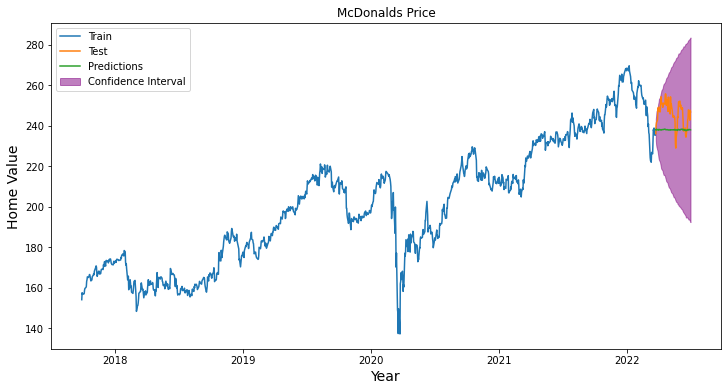

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2019.627
Date:                Sun, 20 Nov 2022   AIC                           4047.254
Time:                        21:07:21   BIC                           4067.367
Sample:                             0   HQIC                          4054.854
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Starbucks     -0.3688      0.084     -4.406      0.000      -0.533      -0.205
deaths      1.788e-05      0.000      0.138      0.890      -0.000       0.000
ar.L1         -0.1044      0.017     -6.302      0.0

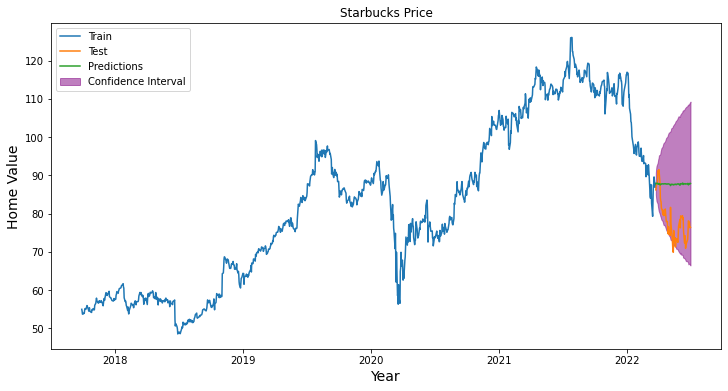

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -5067.441
Date:                Sun, 20 Nov 2022   AIC                          10144.883
Time:                        21:07:24   BIC                          10170.024
Sample:                             0   HQIC                         10154.382
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0537      0.766      1.376      0.169      -0.447       2.554
Chipotle       0.9232      1.372      0.673      0.501      -1.767       3.613
deaths         0.0051      0.001      3.625      0.0

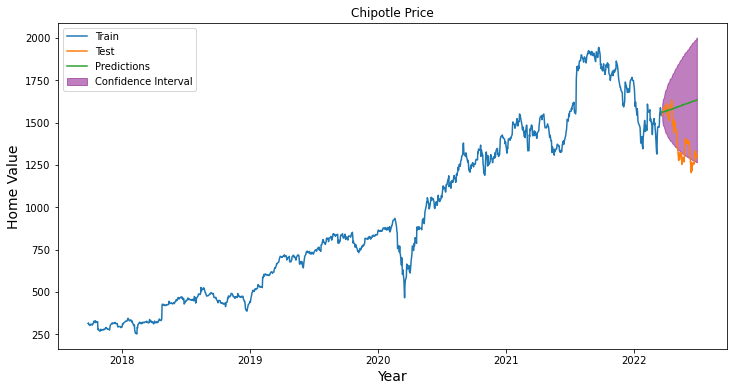

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2028.044
Date:                Sun, 20 Nov 2022   AIC                           4062.088
Time:                        21:07:26   BIC                           4077.173
Sample:                             0   HQIC                          4067.788
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Yum           -0.0496      0.101     -0.494      0.621      -0.247       0.147
deaths      7.354e-05      0.000      0.523      0.601      -0.000       0.000
sigma2         2.1339      0.037     57.390      0.0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1659.761
Date:                Sun, 20 Nov 2022   AIC                           3325.521
Time:                        21:07:28   BIC                           3340.606
Sample:                             0   HQIC                          3331.221
                               - 1129                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Restaurant Brands Int    -0.0612      0.058     -1.061      0.289      -0.174       0.052
deaths                 5.719e-05      0.000      0.506      0.613      -0.000       0.000
sigma2  

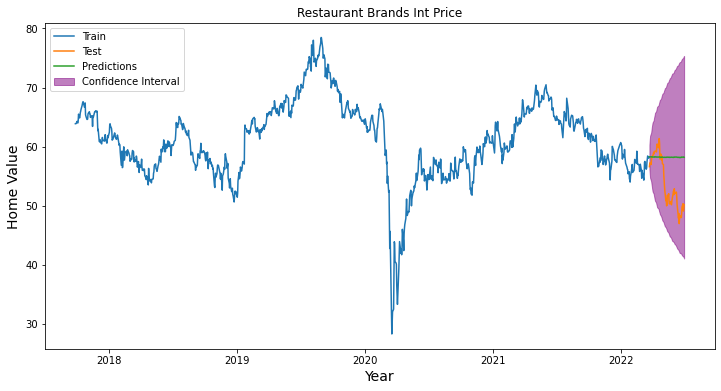

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2633.630
Date:                Sun, 20 Nov 2022   AIC                           5273.260
Time:                        21:07:30   BIC                           5288.345
Sample:                             0   HQIC                          5278.960
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Darden        -0.4717      0.165     -2.867      0.004      -0.794      -0.149
deaths         0.0002      0.000      0.675      0.500      -0.000       0.001
sigma2         6.2444      0.118     53.012      0.0

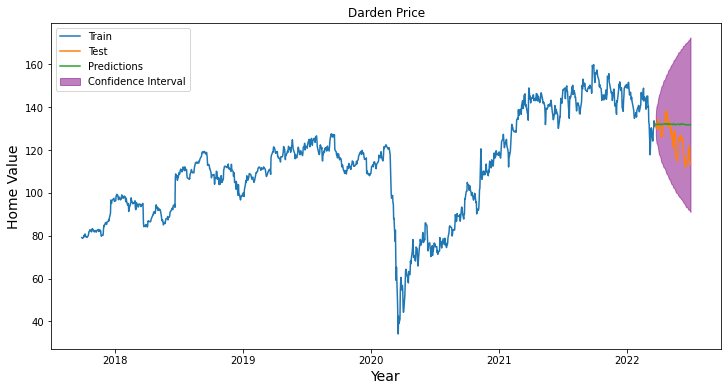

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3755.370
Date:                Sun, 20 Nov 2022   AIC                           7518.740
Time:                        21:07:33   BIC                           7538.853
Sample:                             0   HQIC                          7526.339
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Dominos        0.1040      0.325      0.320      0.749      -0.533       0.741
deaths        -0.0009      0.001     -1.438      0.150      -0.002       0.000
ar.L1         -0.1052      0.023     -4.632      0.0

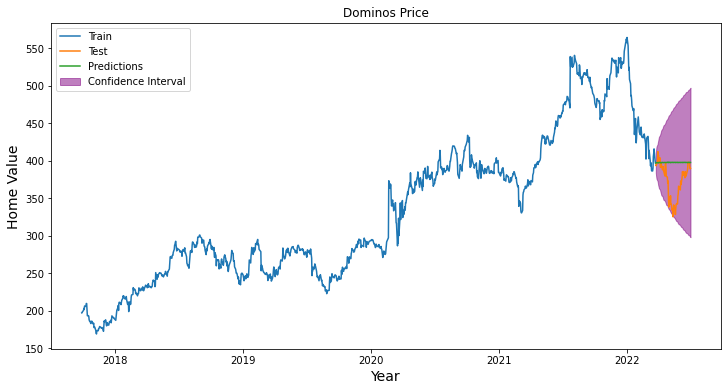

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -733.796
Date:                Sun, 20 Nov 2022   AIC                           1475.591
Time:                        21:07:38   BIC                           1495.704
Sample:                             0   HQIC                          1483.191
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Wendys         0.0941      0.014      6.807      0.000       0.067       0.121
deaths     -1.589e-05   5.59e-05     -0.284      0.776      -0.000    9.36e-05
ar.L1         -0.0921      0.009    -10.614      0.0

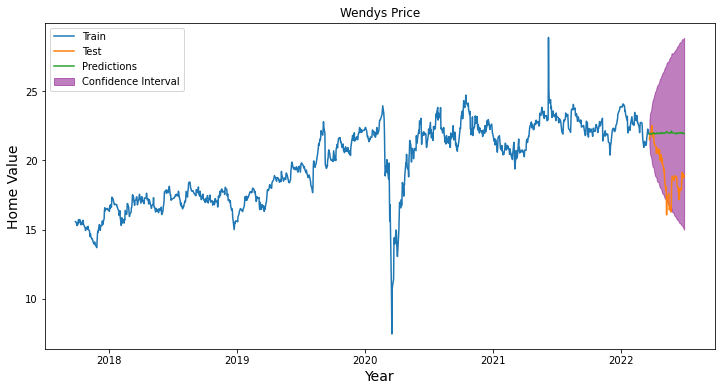

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2802.906
Date:                Sun, 20 Nov 2022   AIC                           5613.811
Time:                        21:07:42   BIC                           5633.924
Sample:                             0   HQIC                          5621.411
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Wingstop      -0.2575      0.128     -2.016      0.044      -0.508      -0.007
deaths         0.0005      0.000      2.288      0.022    7.29e-05       0.001
ar.L1          0.0682      0.020      3.493      0.0

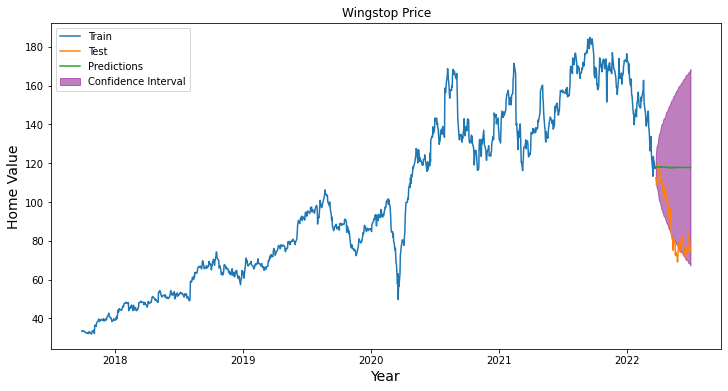

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2333.313
Date:                Sun, 20 Nov 2022   AIC                           4672.626
Time:                        21:07:44   BIC                           4687.711
Sample:                             0   HQIC                          4678.326
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Papa Johns     0.0331      0.078      0.422      0.673      -0.121       0.187
deaths         0.0002      0.000      1.688      0.091   -3.65e-05       0.000
sigma2         3.6666      0.062     58.849      0.0

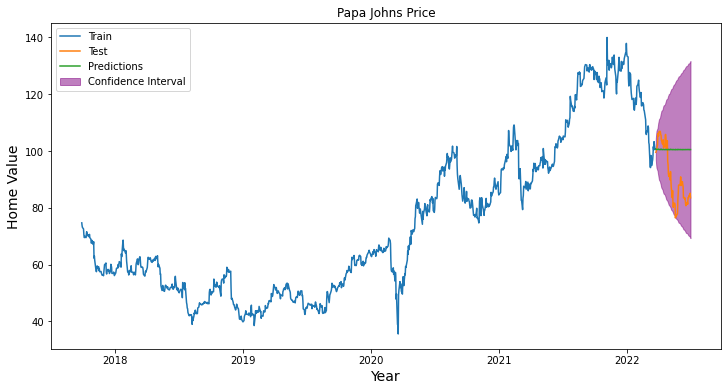

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2880.423
Date:                Sun, 20 Nov 2022   AIC                           5766.845
Time:                        21:07:46   BIC                           5781.930
Sample:                             0   HQIC                          5772.545
                               - 1129                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Cracker Barrel    -0.5413      0.197     -2.750      0.006      -0.927      -0.155
deaths            -0.0003      0.000     -0.972      0.331      -0.001       0.000
sigma2             9.6722      0.207

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2559.117
Date:                Sun, 20 Nov 2022   AIC                           5124.235
Time:                        21:07:49   BIC                           5139.319
Sample:                             0   HQIC                          5129.934
                               - 1129                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Shake Shack     0.3814      0.081      4.738      0.000       0.224       0.539
deaths          0.0004      0.000      2.041      0.041    1.46e-05       0.001
sigma2          5.4720      0.096     56.832    

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -971.883
Date:                Sun, 20 Nov 2022   AIC                           1949.765
Time:                        21:07:51   BIC                           1964.850
Sample:                             0   HQIC                          1955.465
                               - 1129                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Bloomin Brands     0.0189      0.028      0.682      0.495      -0.035       0.073
deaths          4.223e-06   5.81e-05      0.073      0.942      -0.000       0.000
sigma2             0.3279      0.007

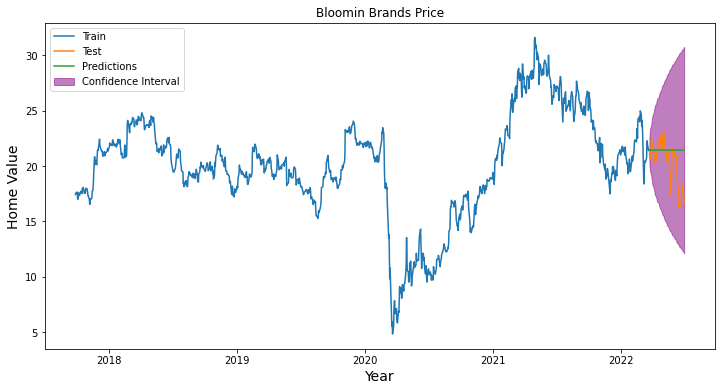

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2292.205
Date:                Sun, 20 Nov 2022   AIC                           4590.411
Time:                        21:07:52   BIC                           4605.495
Sample:                             0   HQIC                          4596.110
                               - 1129                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Jack in the Box    -0.0675      0.093     -0.726      0.468      -0.250       0.115
deaths              0.0001      0.000      0.497      0.619      -0.000       0.001
sigma2              3.4087      

Wall time: 43.1 s


In [47]:
%%time

for x in merged_insample.iloc[:, :14]:
    stonks(merged_insample.iloc[:, :14][x])

stop = timeit.default_timer()

In [48]:
error_dict_percent

{'McDonalds': 3.531687538737728,
 'Starbucks': 13.424791282401568,
 'Chipotle': 14.708718521505995,
 'Yum': 3.3657219152957123,
 'Restaurant Brands Int': 9.594122457229872,
 'Darden': 6.0465700669755265,
 'Dominos': 7.30443334785198,
 'Wendys': 15.067207925721373,
 'Wingstop': 35.00853066531602,
 'Papa Johns': 13.354202243112656,
 'Cracker Barrel': 15.966839919342082,
 'Shake Shack': 34.656865789782366,
 'Bloomin Brands': 7.830470961635871,
 'Jack in the Box': 18.87593339652336}

In [49]:
# Examining the MAPEs by creating a DataFrame of MAPEs
from operator import itemgetter, attrgetter
stocksss_errors= sorted(error_dict_percent.items(), key=itemgetter(0), reverse=True)
pm_stock_diffs_error_per= pd.DataFrame(stocksss_errors)
pm_stock_diffs_error_per.rename( columns={0 :'Stock', 1:'Auto Arima Percent Error'}, inplace=True )


In [50]:
pm_stock_diffs_error_per

Stock  Auto Arima Percent Error
0                     Yum                  3.365722
1                Wingstop                 35.008531
2                  Wendys                 15.067208
3               Starbucks                 13.424791
4             Shake Shack                 34.656866
5   Restaurant Brands Int                  9.594122
6              Papa Johns                 13.354202
7               McDonalds                  3.531688
8         Jack in the Box                 18.875933
9                 Dominos                  7.304433
10                 Darden                  6.046570
11         Cracker Barrel                 15.966840
12               Chipotle                 14.708719
13         Bloomin Brands                  7.830471

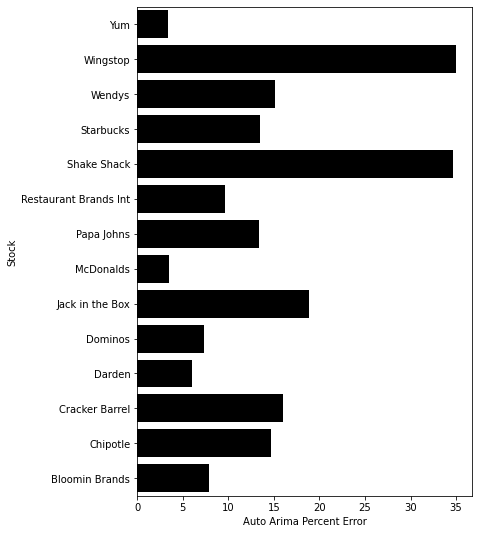

In [51]:
f, ax = plt.subplots(figsize=(6, 9))
sns.barplot(x='Auto Arima Percent Error',y='Stock', data=pm_stock_diffs_error_per, color="black");

## Sktime Prophet Modeling

Those results were surprisingly good but maybe Prophet can do better. After all, it was developed with the business cycle in mind. Because the regular Prophet module has trouble with exogenous variables, I instead used Sktime's Prophet which does allow for exogenous variables

In [52]:


from sktime.forecasting.fbprophet import Prophet
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from sktime.performance_metrics.forecasting import     mean_absolute_percentage_error



Next, I will use the Prophet model so I need to reset the index. Therefore, I will make another DataFrame with a reset index

In [53]:
merged_copy_reset=merged_copy.reset_index(drop=False)

merged_copy_reset

Dates   McDonalds  Starbucks    Chipotle        Yum  \
0    2017-09-27  154.050003  54.990002  313.850006  73.099998   
1    2017-09-28  157.490005  54.500000  316.529999  73.500000   
2    2017-09-29  156.679993  53.709999  307.829987  73.610001   
3    2017-10-02  156.960007  53.810001  301.809998  73.750000   
4    2017-10-03  156.860001  53.990002  302.989990  73.919998   
...         ...         ...        ...         ...        ...   
1321 2022-12-26         NaN        NaN         NaN        NaN   
1322 2022-12-27         NaN        NaN         NaN        NaN   
1323 2022-12-28         NaN        NaN         NaN        NaN   
1324 2022-12-29         NaN        NaN         NaN        NaN   
1325 2022-12-30         NaN        NaN         NaN        NaN   

      Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
0                 63.869999  79.150002  196.839996   15.58  33.540001   
1                 63.880001  78.959999  197.039993   15.57  33.340000   
2                 63.880001  78.779999  198.550003   15.53  33.250000   
3                 64.269997  79.169998  199.990005   15.29  33.610001   
4                 64.040001  80.110001  202.809998   15.47  33.480000   
...                     ...        ...         ...     ...        ...   
1321                    NaN        NaN         NaN     NaN        NaN   
1322                    NaN        NaN         NaN     NaN        NaN   
1323                    NaN        NaN         NaN     NaN        NaN   
1324                    NaN        NaN         NaN     NaN        NaN   
1325                    NaN        NaN         NaN     NaN        NaN   

      Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
0      74.699997      149.550003    32.580002       17.420000   
1      73.660004      150.399994    32.950001       17.510000   
2      73.070000      151.619995    33.230000       17.600000   
3      72.559998      153.899994    33.389999       17.639999   
4      70.610001      153.210007    33.139999       17.170000   
...          ...             ...          ...             ...   
1321         NaN             NaN          NaN             NaN   
1322         NaN             NaN          NaN             NaN   
1323         NaN             NaN          NaN             NaN   
1324         NaN             NaN          NaN             NaN   
1325         NaN             NaN          NaN             NaN   

      Jack in the Box  deaths  
0          100.199997     0.0  
1          101.040001     0.0  
2          101.919998     0.0  
3          100.589996     0.0  
4           99.339996     0.0  
...               ...     ...  
1321              NaN     0.0  
1322              NaN     0.0  
1323              NaN     0.0  
1324              NaN     0.0  
1325              NaN     0.0  

[1326 rows x 16 columns]

In [54]:
prophet_error_dict=dict()
def prophet(data):
    y = data.iloc[:1129]
    test_x=data.iloc[1129 :1198]
    volumex=vol_full[x].to_frame()
    deaths_frame=merged_insample['deaths'].to_frame()
    exog_vars=volumex.merge(deaths_frame, how='left',left_on=volumex.index, right_on=deaths_frame.index)
    exog_vars.drop('key_0', axis=1, inplace=True)
    forecaster = Prophet(freq='d')
    forecaster.fit(y, X=exog_vars.iloc[:1129])
    y_preds = forecaster.predict(fh= np.arange(1, 70), X=exog_vars.iloc[1129:1198, :])
    
    coverage = [0.95]
    y_pred_ints = forecaster.predict_interval(fh=np.arange(1, 70),
                                              X=exog_vars.iloc[1129:1198, :], coverage=0.95)
    y_pred = forecaster.predict(fh= np.arange(1, 70), X=exog_vars.iloc[1129:1198, :])
    print(f'{data.name}  MAPE: %.3f' % (mean_absolute_percentage_error(test_x, y_preds)))
    prophet_percent_error=mean_absolute_percentage_error(test_x, y_preds)*100
    
    fig, ax = plotting.plot_series(y,test_x, y_pred, labels=["Actual Prices", "Test Values","Predicted Prices"])

    ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["Coverage"][0.95]["lower"],
    y_pred_ints["Coverage"][0.95]["upper"],
    alpha=0.6,
    color=ax.get_lines()[-1].get_c(),
    label=f"{coverage} cov.pred.intervals",
    )

    ax.legend();
    
    prophet_error_dict[data.name]=prophet_percent_error


21:07:53 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing


McDonalds  MAPE: 0.095


21:07:56 - cmdstanpy - INFO - Chain [1] start processing
21:07:56 - cmdstanpy - INFO - Chain [1] done processing


Starbucks  MAPE: 0.275


21:07:58 - cmdstanpy - INFO - Chain [1] start processing
21:07:59 - cmdstanpy - INFO - Chain [1] done processing


Chipotle  MAPE: 0.101


21:08:01 - cmdstanpy - INFO - Chain [1] start processing
21:08:01 - cmdstanpy - INFO - Chain [1] done processing


Yum  MAPE: 0.159


21:08:03 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing


Restaurant Brands Int  MAPE: 0.092


21:08:06 - cmdstanpy - INFO - Chain [1] start processing
21:08:06 - cmdstanpy - INFO - Chain [1] done processing


Darden  MAPE: 0.254


21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:09 - cmdstanpy - INFO - Chain [1] done processing


Dominos  MAPE: 0.126


21:08:11 - cmdstanpy - INFO - Chain [1] start processing
21:08:11 - cmdstanpy - INFO - Chain [1] done processing


Wendys  MAPE: 0.254


21:08:13 - cmdstanpy - INFO - Chain [1] start processing
21:08:13 - cmdstanpy - INFO - Chain [1] done processing


Wingstop  MAPE: 0.631


21:08:15 - cmdstanpy - INFO - Chain [1] start processing
21:08:16 - cmdstanpy - INFO - Chain [1] done processing


Papa Johns  MAPE: 0.211


21:08:18 - cmdstanpy - INFO - Chain [1] start processing
21:08:18 - cmdstanpy - INFO - Chain [1] done processing


Cracker Barrel  MAPE: 0.379


21:08:20 - cmdstanpy - INFO - Chain [1] start processing
21:08:20 - cmdstanpy - INFO - Chain [1] done processing


Shake Shack  MAPE: 0.540


21:08:22 - cmdstanpy - INFO - Chain [1] start processing
21:08:22 - cmdstanpy - INFO - Chain [1] done processing


Bloomin Brands  MAPE: 0.213


21:08:24 - cmdstanpy - INFO - Chain [1] start processing
21:08:24 - cmdstanpy - INFO - Chain [1] done processing


Jack in the Box  MAPE: 0.117
Wall time: 33 s


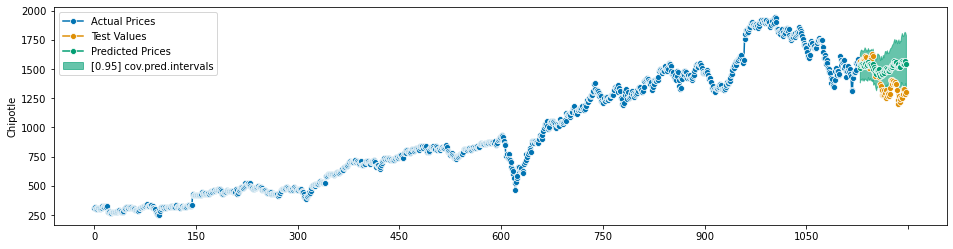

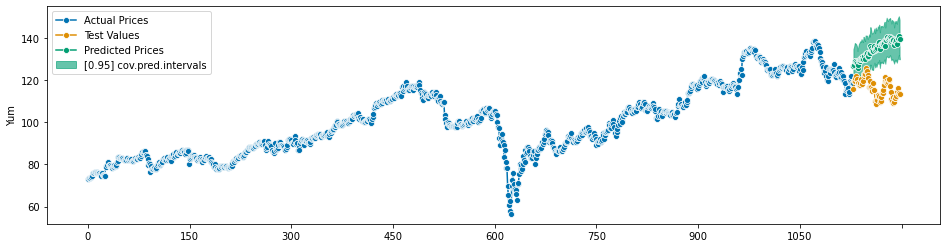

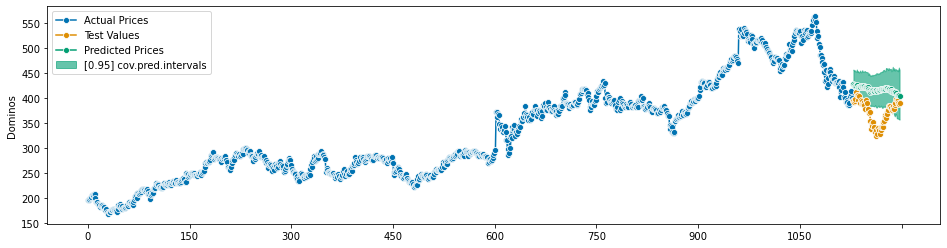

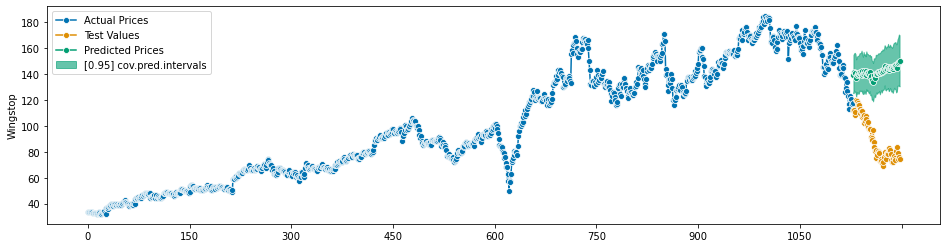

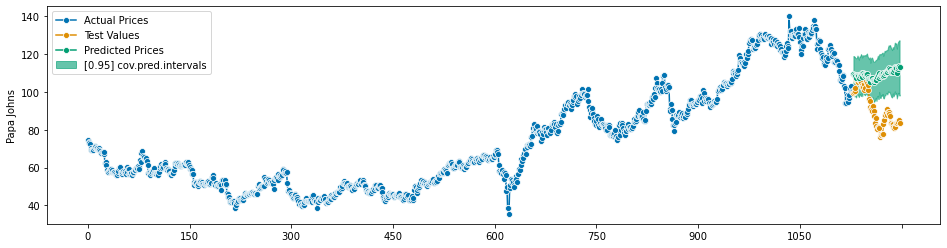

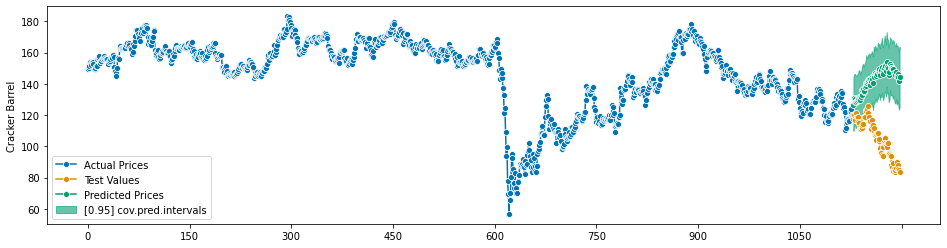

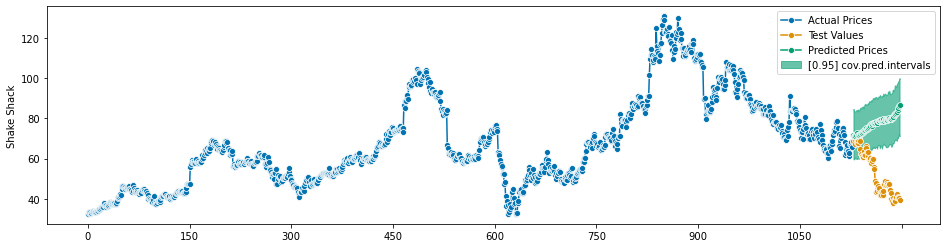

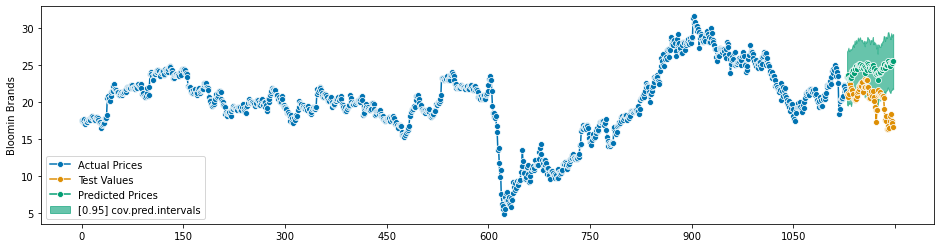

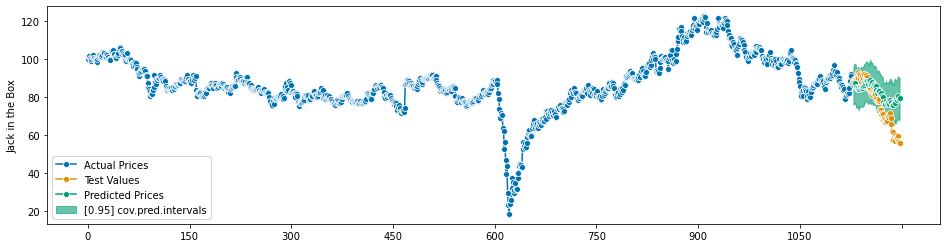

In [55]:
%%time

for x in merged_copy_reset.iloc[:1267, 1:15]:
    prophet(merged_copy_reset.iloc[:1267, 1:15][x])

stop = timeit.default_timer()

In [56]:
prophet_error_dict

{'McDonalds': 9.45541376522143,
 'Starbucks': 27.51159413075075,
 'Chipotle': 10.08578504959042,
 'Yum': 15.934175849046255,
 'Restaurant Brands Int': 9.162873182636687,
 'Darden': 25.424712620481532,
 'Dominos': 12.59629909055368,
 'Wendys': 25.403794623709874,
 'Wingstop': 63.05551633038198,
 'Papa Johns': 21.05623256845318,
 'Cracker Barrel': 37.884868035152955,
 'Shake Shack': 53.97233613877296,
 'Bloomin Brands': 21.316340705509358,
 'Jack in the Box': 11.74329692652412}

In [57]:
#A DataFrame of prophet MAPEs
prophet_errors= sorted(prophet_error_dict.items(), key=itemgetter(0), reverse=False)
pro_stock_diffs_error_per= pd.DataFrame(prophet_errors)
pro_stock_diffs_error_per.rename( columns={0 :'Stock', 1:'Prophet Percent Error'}, inplace=True )
pro_stock_diffs_error_per

Stock  Prophet Percent Error
0          Bloomin Brands              21.316341
1                Chipotle              10.085785
2          Cracker Barrel              37.884868
3                  Darden              25.424713
4                 Dominos              12.596299
5         Jack in the Box              11.743297
6               McDonalds               9.455414
7              Papa Johns              21.056233
8   Restaurant Brands Int               9.162873
9             Shake Shack              53.972336
10              Starbucks              27.511594
11                 Wendys              25.403795
12               Wingstop              63.055516
13                    Yum              15.934176

In [58]:
f, ax = plt.subplots(figsize=(6, 9))
sns.barplot(x='Prophet Percent Error',y='Stock', data=pro_stock_diffs_error_per, color="black");

We can see that the MAPEs are too high to be used. Let's try another model:

# LSTM

First, let's incorporate the death and volume predictions into the data:

In [59]:
death_preds = pd. read_excel ("7day_delay_withmy_preds.xlsx")
death_preds.set_index('ds', inplace=True)
death_preds

y
ds                     
2020-01-23     0.000000
2020-01-24     0.000000
2020-01-25     0.000000
2020-01-26     0.000000
2020-01-27     0.000000
...                 ...
2022-12-26  1089.821129
2022-12-27  1494.408305
2022-12-28  1611.934845
2022-12-29  1470.535711
2022-12-30  1587.359891

[1055 rows x 1 columns]

In [60]:
#Merger of death preds and 
merged_preds=restaurants.merge(death_preds, how='left',left_on=restaurants.index, right_on=death_preds.index)
#merged_preds.fillna(0, inplace=True)
merged_preds.rename(columns={"y": "deaths", "key_0":"Dates"}, inplace=True)
#merged_copy=merged.copy(deep=True)
merged_preds.set_index('Dates', inplace=True)
merged_preds


McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26         NaN        NaN         NaN        NaN   
2022-12-27         NaN        NaN         NaN        NaN   
2022-12-28         NaN        NaN         NaN        NaN   
2022-12-29         NaN        NaN         NaN        NaN   
2022-12-30         NaN        NaN         NaN        NaN   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26                    NaN        NaN         NaN     NaN        NaN   
2022-12-27                    NaN        NaN         NaN     NaN        NaN   
2022-12-28                    NaN        NaN         NaN     NaN        NaN   
2022-12-29                    NaN        NaN         NaN     NaN        NaN   
2022-12-30                    NaN        NaN         NaN     NaN        NaN   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26         NaN             NaN          NaN             NaN   
2022-12-27         NaN             NaN          NaN             NaN   
2022-12-28         NaN             NaN          NaN             NaN   
2022-12-29         NaN             NaN          NaN             NaN   
2022-12-30         NaN             NaN          NaN             NaN   

            Jack in the Box       deaths  
Dates                                     
2017-09-27       100.199997          NaN  
2017-09-28       101.040001          NaN  
2017-09-29       101.919998          NaN  
2017-10-02       100.589996          NaN  
2017-10-03        99.339996          NaN  
...                     ...          ...  
2022-12-26              NaN  1089.821129  
2022-12-27              NaN  1494.408305  
2022-12-28              NaN  1611.934845  
2022-12-29              NaN  1470.535711  
2022-12-30              NaN  1587.359891  

[1326 rows x 15 columns]

In [61]:
#Opening the death predictions
death_preds = pd.read_excel ("7day_delay_withmy_preds.xlsx")
#Merging with restaurants
full_dataset=restaurants.merge(death_preds, how='left',left_on=restaurants.index, right_on=death_preds['ds'])
#Renaming columns
full_dataset.rename(columns={"y": "deaths", "key_0":"Dates"}, inplace=True)
#Creating a copy before I set index
full_dataset_copy=full_dataset.copy(deep=True)
#Dropping columns
full_dataset.drop('ds', axis=1, inplace=True)
full_dataset.drop('deaths', axis=1, inplace=True)

full_dataset.set_index('Dates', inplace=True)
full_dataset

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26         NaN        NaN         NaN        NaN   
2022-12-27         NaN        NaN         NaN        NaN   
2022-12-28         NaN        NaN         NaN        NaN   
2022-12-29         NaN        NaN         NaN        NaN   
2022-12-30         NaN        NaN         NaN        NaN   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26                    NaN        NaN         NaN     NaN        NaN   
2022-12-27                    NaN        NaN         NaN     NaN        NaN   
2022-12-28                    NaN        NaN         NaN     NaN        NaN   
2022-12-29                    NaN        NaN         NaN     NaN        NaN   
2022-12-30                    NaN        NaN         NaN     NaN        NaN   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26         NaN             NaN          NaN             NaN   
2022-12-27         NaN             NaN          NaN             NaN   
2022-12-28         NaN             NaN          NaN             NaN   
2022-12-29         NaN             NaN          NaN             NaN   
2022-12-30         NaN             NaN          NaN             NaN   

            Jack in the Box  
Dates                        
2017-09-27       100.199997  
2017-09-28       101.040001  
2017-09-29       101.919998  
2017-10-02       100.589996  
2017-10-03        99.339996  
...                     ...  
2022-12-26              NaN  
2022-12-27              NaN  
2022-12-28              NaN  
2022-12-29              NaN  
2022-12-30              NaN  

[1326 rows x 14 columns]

In [62]:
full_dataset_copy.iloc[1267:]
#Eliminating nulls
#full_dataset_copy['deaths'].fillna(0, axis=0, inplace=True)
#Setting index
full_dataset_copy.set_index('Dates', inplace=True)
full_dataset_copy

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26         NaN        NaN         NaN        NaN   
2022-12-27         NaN        NaN         NaN        NaN   
2022-12-28         NaN        NaN         NaN        NaN   
2022-12-29         NaN        NaN         NaN        NaN   
2022-12-30         NaN        NaN         NaN        NaN   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26                    NaN        NaN         NaN     NaN        NaN   
2022-12-27                    NaN        NaN         NaN     NaN        NaN   
2022-12-28                    NaN        NaN         NaN     NaN        NaN   
2022-12-29                    NaN        NaN         NaN     NaN        NaN   
2022-12-30                    NaN        NaN         NaN     NaN        NaN   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26         NaN             NaN          NaN             NaN   
2022-12-27         NaN             NaN          NaN             NaN   
2022-12-28         NaN             NaN          NaN             NaN   
2022-12-29         NaN             NaN          NaN             NaN   
2022-12-30         NaN             NaN          NaN             NaN   

            Jack in the Box         ds       deaths  
Dates                                                
2017-09-27       100.199997        NaT          NaN  
2017-09-28       101.040001        NaT          NaN  
2017-09-29       101.919998        NaT          NaN  
2017-10-02       100.589996        NaT          NaN  
2017-10-03        99.339996        NaT          NaN  
...                     ...        ...          ...  
2022-12-26              NaN 2022-12-26  1089.821129  
2022-12-27              NaN 2022-12-27  1494.408305  
2022-12-28              NaN 2022-12-28  1611.934845  
2022-12-29              NaN 2022-12-29  1470.535711  
2022-12-30              NaN 2022-12-30  1587.359891  

[1326 rows x 16 columns]

Now, I will build and evaluate an LSTM model:

Now, for the LSTM error calculation, I am going to use the average of 3 results. For example, instead of using the result for 1 LSTM on McDonald's stock, I am using the average of 3 results to determine the reliability of the results. **Spoiler: LSTM performed best. I did this many time and LSTM always did well. Therefore, I will use this space to also make predictions.**

In [63]:
%%time
roi=dict();
profit=[]
profs=[]
death_nums= full_dataset_copy[['deaths']]
stock_error=dict();
mapes=[]
total=[]
loops=3
#This will allow me to do 3 loops. 
for n in range(loops):

    

    for x in full_dataset.iloc[:,:]:
        volumex=vol_full[x].to_frame()
        deaths_frame=full_dataset_copy['deaths'].to_frame()
        exog_vars=volumex.merge(deaths_frame, how='left',left_on=volumex.index, right_on=deaths_frame.index)
        exog_vars.set_index('key_0', inplace=True)      
        #Making a DataFrame that contains only the selected stock and the death numbers
        exogenous_df=exog_vars.merge(merged_copy[x], how='left',left_on=exog_vars.index, right_on=full_dataset.iloc[:,:][x].index)
        exogenous_df.set_index('key_0', inplace=True)
        exogenous_df.fillna(full_dataset.iloc[1190:1265,:][x].mean(), axis=1, inplace=True)

        #Creating training set
        training = exogenous_df.iloc[:1129]

        #"next_" would be properly called a validation set
        next_= exogenous_df.iloc[1129:1200]
        
        future_values= exogenous_df.iloc[1265:]
    
        # Using the create_dataset function to make the DataFrame values into tensors. 
        xtrain, ytrain = create_dataset(training, training.iloc[:,2],2)#Using a lag of 2 to reflect market's responsiveness
        xnext, ynext=create_dataset(next_, next_.iloc[:,2],2)
        xfuture, yfuture=create_dataset(future_values, future_values.iloc[:,2],2)
        model_1 = Sequential()
        model_1.add(LSTM(69,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2] )))
        model_1.add(Dense(25))
        model_1.add(Dense(1))
        model_1.compile(loss="mean_squared_error", optimizer="adam")

        model_1.fit(xtrain, ytrain,
                    epochs=10,
                    batch_size=10,
                    verbose=1,
                    shuffle=False
                   )

        ypred = model_1.predict(xnext)
        print(x,'equity mape', (mean_absolute_percentage_error(ypred, next_.iloc[:69,2])))
   
        ypred = asarray(ypred)
        for pred in ypred[:]:
            interval = 1.96 * ypred.std()
            lower, upper = ypred - interval, ypred + interval
        # Remove comments below to see graphs
        #plt.figure(figsize=(12,7))
        #plt.plot(merged_copy.index[1129:1198], ypred, 'r', label="Predictions")
        #plt.plot(merged_copy.index[1129:1198], next_.iloc[:69,2], 'b', label="Actual")
        #plt.fill_between(merged_copy.index[1129:1198], lower[:, 0], upper[:, 0], color="green", alpha=0.5)
        #plt.xlabel("Date")
        #plt.ylabel("Day End Price")
        #plt.legend(['Predictions', 'Actual Prices', 'Confidence Intervals'], loc='upper left')    

        #plt.title(f'{x} Price over Time')
        
        mape_=mean_absolute_percentage_error(ypred, next_.iloc[:69,2])
        stock_error[x]=mape_

        total.append(stock_error[x])
        mapes.append(total)
        
        ypred_1 = model_1.predict(xfuture)
        ypred_1_array = asarray(ypred_1)
    
        for preds in ypred_1_array[:]:
            interval = 1.96 * ypred_1_array.std()
            lower, upper = ypred_1_array - interval, ypred_1_array + interval

        #Remove comments below to graph each result
        #plt.figure(figsize=(12,7))
        #plt.plot(merged_copy.index[:1267], full_dataset[x][:1267], 'green', label='Actual Prices')
        #plt.plot(merged_copy.index[1267:], ypred_1_array, 'r', label="Predictions")
    
        #plt.fill_between(merged_copy.index[1267:], lower[:, 0], upper[:, 0], color="purple", alpha=0.5)
        #plt.xlabel("Date")
        #plt.ylabel("Day End Price")
        #plt.legend([ 'Actual Prices', ' Predictions'], loc='upper left')
        #plt.title(f'{x} Future Closing Price')
        
        final_observed=full_dataset[x][1266]
    
        diff=ypred_1[58,0]-full_dataset[x][1266]
        rois=diff/final_observed
        
        roi[x]=rois*100
        profit.append(roi[x])
        profs.append(profit)

       
stop = timeit.default_timer()



Epoch 1/10
113/113 [==============================] - 2s 2ms/step - loss: 10744.3936
Epoch 2/10
113/113 [==============================] - 0s 2ms/step - loss: 2749.6296
Epoch 3/10
113/113 [==============================] - 0s 2ms/step - loss: 1947.7109
Epoch 4/10
113/113 [==============================] - 0s 2ms/step - loss: 3090.6760
Epoch 5/10
113/113 [==============================] - 0s 2ms/step - loss: 2181.5571
Epoch 6/10
113/113 [==============================] - 0s 2ms/step - loss: 860.1442
Epoch 7/10
113/113 [==============================] - 0s 2ms/step - loss: 661.8120
Epoch 8/10
113/113 [==============================] - 0s 2ms/step - loss: 354.9547
Epoch 9/10
113/113 [==============================] - 0s 2ms/step - loss: 347.2283
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
McDonalds equity mape 0.08374632707561844
2/2 [==============================] - 0s 0s/step
Epoch 1/10
113/113 [==============================] - 2s 2ms/step - loss: 19656.5098
Epoch 2

113/113 [==============================] - 0s 2ms/step - loss: 1488.3240
Epoch 6/10
113/113 [==============================] - 0s 2ms/step - loss: 1223.0946
Epoch 7/10
113/113 [==============================] - 0s 2ms/step - loss: 341.1817
Epoch 8/10
113/113 [==============================] - 0s 2ms/step - loss: 397.5077
Epoch 9/10
113/113 [==============================] - 0s 2ms/step - loss: 229.3545
Epoch 10/10
3/3 [==============================] - 0s 0s/step
Wingstop equity mape 0.08088623403273884
2/2 [==============================] - 0s 0s/step
Epoch 1/10
113/113 [==============================] - 2s 3ms/step - loss: 1208.3682
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 754.0264
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 893.8941
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 444.3514
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 777.3110
Epoch 6/10
113/113 [=====

113/113 [==============================] - 0s 3ms/step - loss: 2194.5684
Epoch 10/10
3/3 [==============================] - 0s 0s/step
Chipotle equity mape 0.017312018015737174
2/2 [==============================] - 0s 0s/step
Epoch 1/10
113/113 [==============================] - 2s 3ms/step - loss: 19039.0957
Epoch 2/10
113/113 [==============================] - 0s 2ms/step - loss: 1227.3794
Epoch 3/10
113/113 [==============================] - 0s 2ms/step - loss: 834.9959
Epoch 4/10
113/113 [==============================] - 0s 2ms/step - loss: 1377.0415
Epoch 5/10
113/113 [==============================] - 0s 2ms/step - loss: 551.7253
Epoch 6/10
113/113 [==============================] - 0s 2ms/step - loss: 148.9321
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 812.0637
Epoch 8/10
113/113 [==============================] - 0s 2ms/step - loss: 189.6518
Epoch 9/10
113/113 [==============================] - 0s 3ms/step - loss: 314.0144
Epoch 10/10
3/3 [=====

Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 639.8697
Epoch 3/10
113/113 [==============================] - 0s 2ms/step - loss: 379.7403
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 424.6512
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 327.1035
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 430.8985
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 114.0583
Epoch 8/10
113/113 [==============================] - 0s 3ms/step - loss: 37.4689
Epoch 9/10
113/113 [==============================] - 0s 3ms/step - loss: 33.6849
Epoch 10/10
3/3 [==============================] - 0s 0s/step
Shake Shack equity mape 0.05849122032497217
2/2 [==============================] - 0s 0s/step
Epoch 1/10
113/113 [==============================] - 2s 3ms/step - loss: 5355.9858
Epoch 2/10
113/113 [==============================] - 0s 2ms/step - loss: 128.4843
Epoch 3/10
113/

113/113 [==============================] - 0s 3ms/step - loss: 669.6312
Epoch 7/10
113/113 [==============================] - 0s 2ms/step - loss: 384.9826
Epoch 8/10
113/113 [==============================] - 0s 2ms/step - loss: 401.4625
Epoch 9/10
113/113 [==============================] - 0s 2ms/step - loss: 448.0654
Epoch 10/10
3/3 [==============================] - 0s 0s/step
Darden equity mape 0.07796495679627582
2/2 [==============================] - 0s 16ms/step
Epoch 1/10
113/113 [==============================] - 2s 3ms/step - loss: 13200.9326
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 5782.5767
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 3273.0972
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 1982.6069
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 1378.2339
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 477.5393
Epoch 7/10
113/113 [==

3/3 [==============================] - 0s 8ms/step
Jack in the Box equity mape 0.04675371065223404
2/2 [==============================] - 0s 0s/step
Wall time: 3min 24s


In [64]:
# Putting numbers on each MAPE
dicts = {}
length=3
keys = range(length)
values =[total]

nn=dict(list(enumerate(total)))
nn

{0: 0.08374632707561844,
 1: 0.2712408085300191,
 2: 0.041744270953597826,
 3: 0.05572335367946596,
 4: 0.0892353610068211,
 5: 0.08024039471863653,
 6: 0.06356278554177808,
 7: 0.502404081980407,
 8: 0.08088623403273884,
 9: 0.046692953958878715,
 10: 0.11673542492329994,
 11: 0.11648295115449372,
 12: 1.7511728426650375,
 13: 0.12265066595928835,
 14: 0.034314889494213,
 15: 0.36544552488635845,
 16: 0.017312018015737174,
 17: 0.08614350575866418,
 18: 0.15453910598706175,
 19: 0.04336780960084264,
 20: 0.03182867686371805,
 21: 0.6549371347778771,
 22: 0.058157451402339196,
 23: 0.08469386843771382,
 24: 0.08999875113269226,
 25: 0.05849122032497217,
 26: 0.3781016534150762,
 27: 0.05770034439570697,
 28: 0.05305764752079332,
 29: 0.1108359762945377,
 30: 0.02091751248469723,
 31: 0.40372908087393405,
 32: 0.12114350661937393,
 33: 0.07796495679627582,
 34: 0.06738375212925106,
 35: 0.8548494796778568,
 36: 0.10572651382167761,
 37: 0.2230508742641239,
 38: 0.11662599056425894,
 39:

In [65]:
names=[x for x in merged_copy.iloc[:, :14]]
names*3

['McDonalds',
 'Starbucks',
 'Chipotle',
 'Yum',
 'Restaurant Brands Int',
 'Darden',
 'Dominos',
 'Wendys',
 'Wingstop',
 'Papa Johns',
 'Cracker Barrel',
 'Shake Shack',
 'Bloomin Brands',
 'Jack in the Box',
 'McDonalds',
 'Starbucks',
 'Chipotle',
 'Yum',
 'Restaurant Brands Int',
 'Darden',
 'Dominos',
 'Wendys',
 'Wingstop',
 'Papa Johns',
 'Cracker Barrel',
 'Shake Shack',
 'Bloomin Brands',
 'Jack in the Box',
 'McDonalds',
 'Starbucks',
 'Chipotle',
 'Yum',
 'Restaurant Brands Int',
 'Darden',
 'Dominos',
 'Wendys',
 'Wingstop',
 'Papa Johns',
 'Cracker Barrel',
 'Shake Shack',
 'Bloomin Brands',
 'Jack in the Box']

In [66]:
#DataFrame OF LSTM MAPEs
lstm_errors= sorted(nn.items(), key=itemgetter(0), reverse=False)
lstm_errors_per= pd.DataFrame(lstm_errors)
lstm_errors_per.rename( columns={0 :'Stock', 1:'LSTM MAPE'}, inplace=True )
lstm_errors_per['Equity']=names*3
lstm_errors_per['LSTM MAPE']=lstm_errors_per['LSTM MAPE']*100
lstm_errors_per


Stock   LSTM MAPE                 Equity
0       0    8.374633              McDonalds
1       1   27.124081              Starbucks
2       2    4.174427               Chipotle
3       3    5.572335                    Yum
4       4    8.923536  Restaurant Brands Int
5       5    8.024039                 Darden
6       6    6.356279                Dominos
7       7   50.240408                 Wendys
8       8    8.088623               Wingstop
9       9    4.669295             Papa Johns
10     10   11.673542         Cracker Barrel
11     11   11.648295            Shake Shack
12     12  175.117284         Bloomin Brands
13     13   12.265067        Jack in the Box
14     14    3.431489              McDonalds
15     15   36.544552              Starbucks
16     16    1.731202               Chipotle
17     17    8.614351                    Yum
18     18   15.453911  Restaurant Brands Int
19     19    4.336781                 Darden
20     20    3.182868                Dominos
21     21   65.493713                 Wendys
22     22    5.815745               Wingstop
23     23    8.469387             Papa Johns
24     24    8.999875         Cracker Barrel
25     25    5.849122            Shake Shack
26     26   37.810165         Bloomin Brands
27     27    5.770034        Jack in the Box
28     28    5.305765              McDonalds
29     29   11.083598              Starbucks
30     30    2.091751               Chipotle
31     31   40.372908                    Yum
32     32   12.114351  Restaurant Brands Int
33     33    7.796496                 Darden
34     34    6.738375                Dominos
35     35   85.484948                 Wendys
36     36   10.572651               Wingstop
37     37   22.305087             Papa Johns
38     38   11.662599         Cracker Barrel
39     39   17.875292            Shake Shack
40     40   88.995327         Bloomin Brands
41     41    4.675371        Jack in the Box

#  Results

In [67]:
error_means=lstm_errors_per.groupby(['Equity']).mean()
error_means.drop(['Stock'], axis=1, inplace=True)
error_means.reset_index(drop=False, inplace=True)
error_means.rename( columns={'LSTM MAPE' :'Average LSTM MAPE'}, inplace=True )

error_means

Equity  Average LSTM MAPE
0          Bloomin Brands         100.640925
1                Chipotle           2.665793
2          Cracker Barrel          10.778672
3                  Darden           6.719105
4                 Dominos           5.425840
5         Jack in the Box           7.570157
6               McDonalds           5.703962
7              Papa Johns          11.814590
8   Restaurant Brands Int          12.163932
9             Shake Shack          11.790903
10              Starbucks          24.917410
11                 Wendys          67.073023
12               Wingstop           8.159007
13                    Yum          18.186531

Ok, I will eliminate any stock that has an Average MAPE over 15% from contention for top 3 and bottom 3 because I can't trust any predictions from them. Therefore, **Bloomin Brands, Wendys, Starbucks, and Yum are all eliminated**.

In [68]:
fig, ax = plt.subplots(figsize=(20, 18))
sns.boxplot(data=lstm_errors_per, x='Equity', y='LSTM MAPE')
ax.set_title('MAPE Error Distribution')
plt.show()

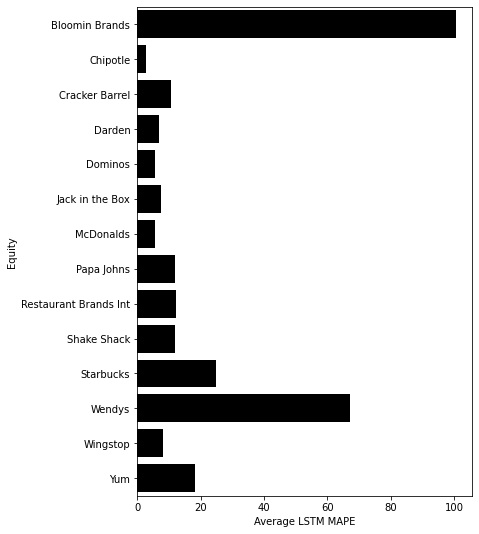

In [69]:
f, ax = plt.subplots(figsize=(6, 9))
sns.barplot(x='Average LSTM MAPE',y='Equity', data=error_means, color="black");

That's not bad but the outliers really harm the model. Also, different iterations of this model will yield different results because LSTMs are stochastic however I did run this many time and the values are similar. 

Let's evaluate model results to see which is the best to use. I would like to use a Group bar chart so we are going to have to combine all of the error values into a DataFrame.

In [70]:
# The names of the new 'model' columns
pm='Auto.arima'
lstm='LSTM'
prop='Prophet'
# Creating the columns
lstm_errors_per = error_means.assign(model=[lstm for x in range(14)])
pm_stock_diffs_error_per=pm_stock_diffs_error_per.assign(model=[pm for x in range(len(pm_stock_diffs_error_per.index))])
pro_stock_diffs_error_per=pro_stock_diffs_error_per.assign(model=[prop for x in range(len(pro_stock_diffs_error_per.index))])
lstm_errors_per

Equity  Average LSTM MAPE model
0          Bloomin Brands         100.640925  LSTM
1                Chipotle           2.665793  LSTM
2          Cracker Barrel          10.778672  LSTM
3                  Darden           6.719105  LSTM
4                 Dominos           5.425840  LSTM
5         Jack in the Box           7.570157  LSTM
6               McDonalds           5.703962  LSTM
7              Papa Johns          11.814590  LSTM
8   Restaurant Brands Int          12.163932  LSTM
9             Shake Shack          11.790903  LSTM
10              Starbucks          24.917410  LSTM
11                 Wendys          67.073023  LSTM
12               Wingstop           8.159007  LSTM
13                    Yum          18.186531  LSTM

In [71]:
#Concatenating columns
errors_combined=pd.concat([lstm_errors_per, pm_stock_diffs_error_per,pro_stock_diffs_error_per])
errors_combined.reset_index(drop=False)
errors_combined

Equity  Average LSTM MAPE       model  \
0          Bloomin Brands         100.640925        LSTM   
1                Chipotle           2.665793        LSTM   
2          Cracker Barrel          10.778672        LSTM   
3                  Darden           6.719105        LSTM   
4                 Dominos           5.425840        LSTM   
5         Jack in the Box           7.570157        LSTM   
6               McDonalds           5.703962        LSTM   
7              Papa Johns          11.814590        LSTM   
8   Restaurant Brands Int          12.163932        LSTM   
9             Shake Shack          11.790903        LSTM   
10              Starbucks          24.917410        LSTM   
11                 Wendys          67.073023        LSTM   
12               Wingstop           8.159007        LSTM   
13                    Yum          18.186531        LSTM   
0                     NaN                NaN  Auto.arima   
1                     NaN                NaN  Auto.arima   
2                     NaN                NaN  Auto.arima   
3                     NaN                NaN  Auto.arima   
4                     NaN                NaN  Auto.arima   
5                     NaN                NaN  Auto.arima   
6                     NaN                NaN  Auto.arima   
7                     NaN                NaN  Auto.arima   
8                     NaN                NaN  Auto.arima   
9                     NaN                NaN  Auto.arima   
10                    NaN                NaN  Auto.arima   
11                    NaN                NaN  Auto.arima   
12                    NaN                NaN  Auto.arima   
13                    NaN                NaN  Auto.arima   
0                     NaN                NaN     Prophet   
1                     NaN                NaN     Prophet   
2                     NaN                NaN     Prophet   
3                     NaN                NaN     Prophet   
4                     NaN                NaN     Prophet   
5                     NaN                NaN     Prophet   
6                     NaN                NaN     Prophet   
7                     NaN                NaN     Prophet   
8                     NaN                NaN     Prophet   
9                     NaN                NaN     Prophet   
10                    NaN                NaN     Prophet   
11                    NaN                NaN     Prophet   
12                    NaN                NaN     Prophet   
13                    NaN                NaN     Prophet   

                    Stock  Auto Arima Percent Error  Prophet Percent Error  
0                     NaN                       NaN                    NaN  
1                     NaN                       NaN                    NaN  
2                     NaN                       NaN                    NaN  
3                     NaN                       NaN                    NaN  
4                     NaN                       NaN                    NaN  
5                     NaN                       NaN                    NaN  
6                     NaN                       NaN                    NaN  
7                     NaN                       NaN                    NaN  
8                     NaN                       NaN                    NaN  
9                     NaN                       NaN                    NaN  
10                    NaN                       NaN                    NaN  
11                    NaN                       NaN                    NaN  
12                    NaN                       NaN                    NaN  
13                    NaN                       NaN                    NaN  
0                     Yum                  3.365722                    NaN  
1                Wingstop                 35.008531                    NaN  
2                  Wendys                 15.067208                    NaN  
3               Starbucks                 13.424791 

In [72]:
# Filling the NaNs and adding the error columns together.
errors_combined.fillna(0, inplace=True)
errors_combined['errors']=errors_combined['Average LSTM MAPE']+ errors_combined['Auto Arima Percent Error']+errors_combined['Prophet Percent Error']

errors_combined['Stock'].iloc[:14]=errors_combined['Equity'].iloc[:14]
errors_combined

Equity  Average LSTM MAPE       model  \
0          Bloomin Brands         100.640925        LSTM   
1                Chipotle           2.665793        LSTM   
2          Cracker Barrel          10.778672        LSTM   
3                  Darden           6.719105        LSTM   
4                 Dominos           5.425840        LSTM   
5         Jack in the Box           7.570157        LSTM   
6               McDonalds           5.703962        LSTM   
7              Papa Johns          11.814590        LSTM   
8   Restaurant Brands Int          12.163932        LSTM   
9             Shake Shack          11.790903        LSTM   
10              Starbucks          24.917410        LSTM   
11                 Wendys          67.073023        LSTM   
12               Wingstop           8.159007        LSTM   
13                    Yum          18.186531        LSTM   
0                       0           0.000000  Auto.arima   
1                       0           0.000000  Auto.arima   
2                       0           0.000000  Auto.arima   
3                       0           0.000000  Auto.arima   
4                       0           0.000000  Auto.arima   
5                       0           0.000000  Auto.arima   
6                       0           0.000000  Auto.arima   
7                       0           0.000000  Auto.arima   
8                       0           0.000000  Auto.arima   
9                       0           0.000000  Auto.arima   
10                      0           0.000000  Auto.arima   
11                      0           0.000000  Auto.arima   
12                      0           0.000000  Auto.arima   
13                      0           0.000000  Auto.arima   
0                       0           0.000000     Prophet   
1                       0           0.000000     Prophet   
2                       0           0.000000     Prophet   
3                       0           0.000000     Prophet   
4                       0           0.000000     Prophet   
5                       0           0.000000     Prophet   
6                       0           0.000000     Prophet   
7                       0           0.000000     Prophet   
8                       0           0.000000     Prophet   
9                       0           0.000000     Prophet   
10                      0           0.000000     Prophet   
11                      0           0.000000     Prophet   
12                      0           0.000000     Prophet   
13                      0           0.000000     Prophet   

                    Stock  Auto Arima Percent Error  Prophet Percent Error  \
0          Bloomin Brands                  0.000000               0.000000   
1                Chipotle                  0.000000               0.000000   
2          Cracker Barrel                  0.000000               0.000000   
3                  Darden                  0.000000               0.000000   
4                 Dominos                  0.000000               0.000000   
5         Jack in the Box                  0.000000               0.000000   
6               McDonalds                  0.000000               0.000000   
7              Papa Johns                  0.000000               0.000000   
8   Restaurant Brands Int                  0.000000               0.000000   
9             Shake Shack                  0.000000               0.000000   
10              Starbucks                  0.000000               0.000000   
11                 Wendys                  0.000000               0.000000   
12               Wingstop                  0.000000               0.000000   
13                    Yum                  0.000000               0.000000   
0                     Yum                  3.365722               0.000000   
1                Wingstop                 35.008531               0.000000   
2                  Wendys                 15.067208               0.000000   
3               Starbucks         

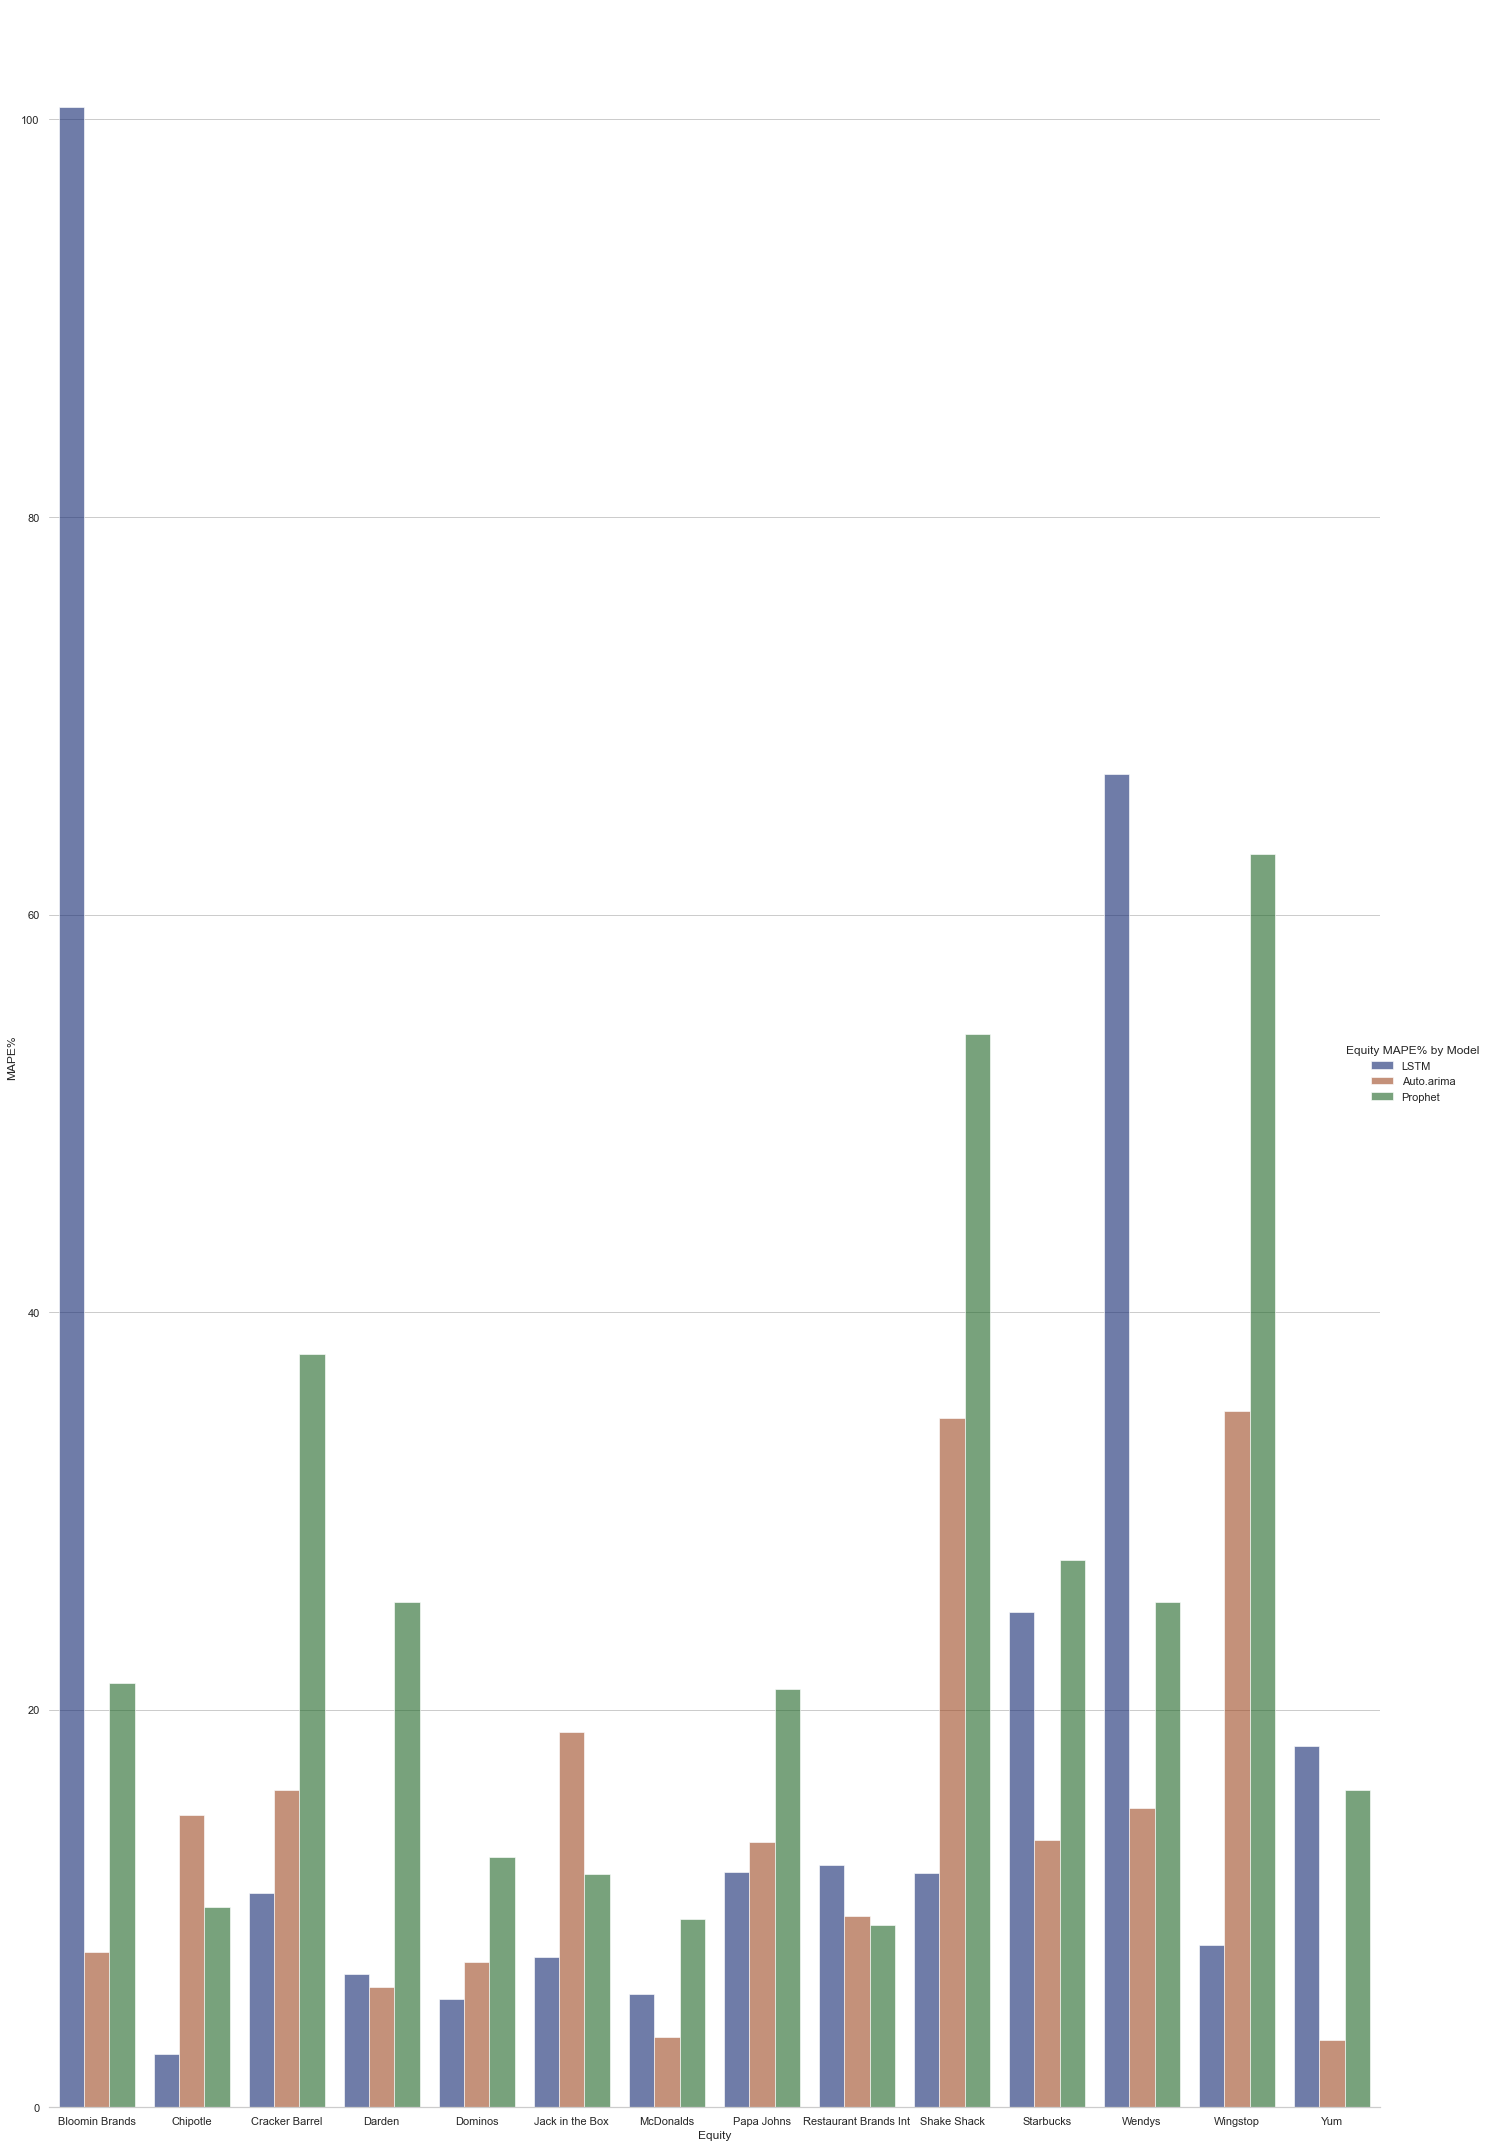

In [73]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_theme(style="whitegrid")
#plt.figure(figsize=(30,20))
g = sns.catplot(
data=errors_combined, kind="bar",
x="Stock", y="errors", hue="model",
palette="dark", alpha=.6, height=30, aspect=.65
)
g.despine(left=True)
g.set_axis_labels("Equity", "MAPE%")
g.legend.set_title("Equity MAPE% by Model")

The Auto.Arima model was surprisingly good. However, I will still go with the LSTM model because its performance was better but was harmed by a few serious outliers. I will have to either disregard predictions on those equities or be very cautious when drawing conclusions from them.

In [74]:
dicts = {}
length=14
keys = range(length)
values =[profit]

profits=dict(list(enumerate(profit)))
profits

{0: 0.07821550970037942,
 1: -35.87739355575349,
 2: 1.6759372270202249,
 3: -17.19469248860005,
 4: -7.812141501591328,
 5: 5.708627050555934,
 6: 28.74904546697647,
 7: 5.8860998503200594,
 8: -10.950886638384501,
 9: 32.616284147694685,
 10: 5.602450029259496,
 11: -10.719653579146527,
 12: -72.99232019865808,
 13: -5.523232552518813,
 14: 11.924182939776847,
 15: -47.917924644507906,
 16: 3.3526452087143714,
 17: -24.18228075172273,
 18: 4.055264282809957,
 19: 2.2460631571537633,
 20: 18.396190928090828,
 21: -15.991937926926544,
 22: -37.90304274333088,
 23: 12.31640708536759,
 24: -17.74279644998975,
 25: 0.6386749339476516,
 26: -5.004580158832642,
 27: -5.966747883570235,
 28: -20.361494853395435,
 29: -28.891636593018845,
 30: 1.2677921368814487,
 31: -10.956554085407493,
 32: -11.634473995733073,
 33: -14.00541520572067,
 34: 30.024831986042233,
 35: -44.82869752414564,
 36: -10.699506650244501,
 37: 11.25863396850656,
 38: -18.9816699645896,
 39: -8.74891185127302,
 40: -25

In [75]:
equity_rois= sorted(profits.items(), key=itemgetter(0), reverse=False)
equity_rois_per= pd.DataFrame(equity_rois)
equity_rois_per.rename( columns={0 :'Stock', 1:'ROI'}, inplace=True )
equity_rois_per['Equity']=names*3
equity_rois_per

Stock        ROI                 Equity
0       0   0.078216              McDonalds
1       1 -35.877394              Starbucks
2       2   1.675937               Chipotle
3       3 -17.194692                    Yum
4       4  -7.812142  Restaurant Brands Int
5       5   5.708627                 Darden
6       6  28.749045                Dominos
7       7   5.886100                 Wendys
8       8 -10.950887               Wingstop
9       9  32.616284             Papa Johns
10     10   5.602450         Cracker Barrel
11     11 -10.719654            Shake Shack
12     12 -72.992320         Bloomin Brands
13     13  -5.523233        Jack in the Box
14     14  11.924183              McDonalds
15     15 -47.917925              Starbucks
16     16   3.352645               Chipotle
17     17 -24.182281                    Yum
18     18   4.055264  Restaurant Brands Int
19     19   2.246063                 Darden
20     20  18.396191                Dominos
21     21 -15.991938                 Wendys
22     22 -37.903043               Wingstop
23     23  12.316407             Papa Johns
24     24 -17.742796         Cracker Barrel
25     25   0.638675            Shake Shack
26     26  -5.004580         Bloomin Brands
27     27  -5.966748        Jack in the Box
28     28 -20.361495              McDonalds
29     29 -28.891637              Starbucks
30     30   1.267792               Chipotle
31     31 -10.956554                    Yum
32     32 -11.634474  Restaurant Brands Int
33     33 -14.005415                 Darden
34     34  30.024832                Dominos
35     35 -44.828698                 Wendys
36     36 -10.699507               Wingstop
37     37  11.258634             Papa Johns
38     38 -18.981670         Cracker Barrel
39     39  -8.748912            Shake Shack
40     40 -25.675436         Bloomin Brands
41     41 -13.601919        Jack in the Box

In [76]:
roi_means=equity_rois_per.groupby(['Equity']).mean()
roi_means.drop(['Stock'], axis=1, inplace=True)
roi_means.reset_index(drop=False, inplace=True)
roi_means.rename( columns={'ROI':'Average ROI'}, inplace=True )

roi_means

Equity  Average ROI
0          Bloomin Brands   -34.557446
1                Chipotle     2.098792
2          Cracker Barrel   -10.374005
3                  Darden    -2.016908
4                 Dominos    25.723356
5         Jack in the Box    -8.363967
6               McDonalds    -2.786365
7              Papa Johns    18.730442
8   Restaurant Brands Int    -5.130450
9             Shake Shack    -6.276630
10              Starbucks   -37.562318
11                 Wendys   -18.311512
12               Wingstop   -19.851145
13                    Yum   -17.444509

**The top 3 were Dominos, Papa Johns, and Chipotle while the bottom 3 were Wingstop, Cracker Barrel, and Jack in the Box  .**

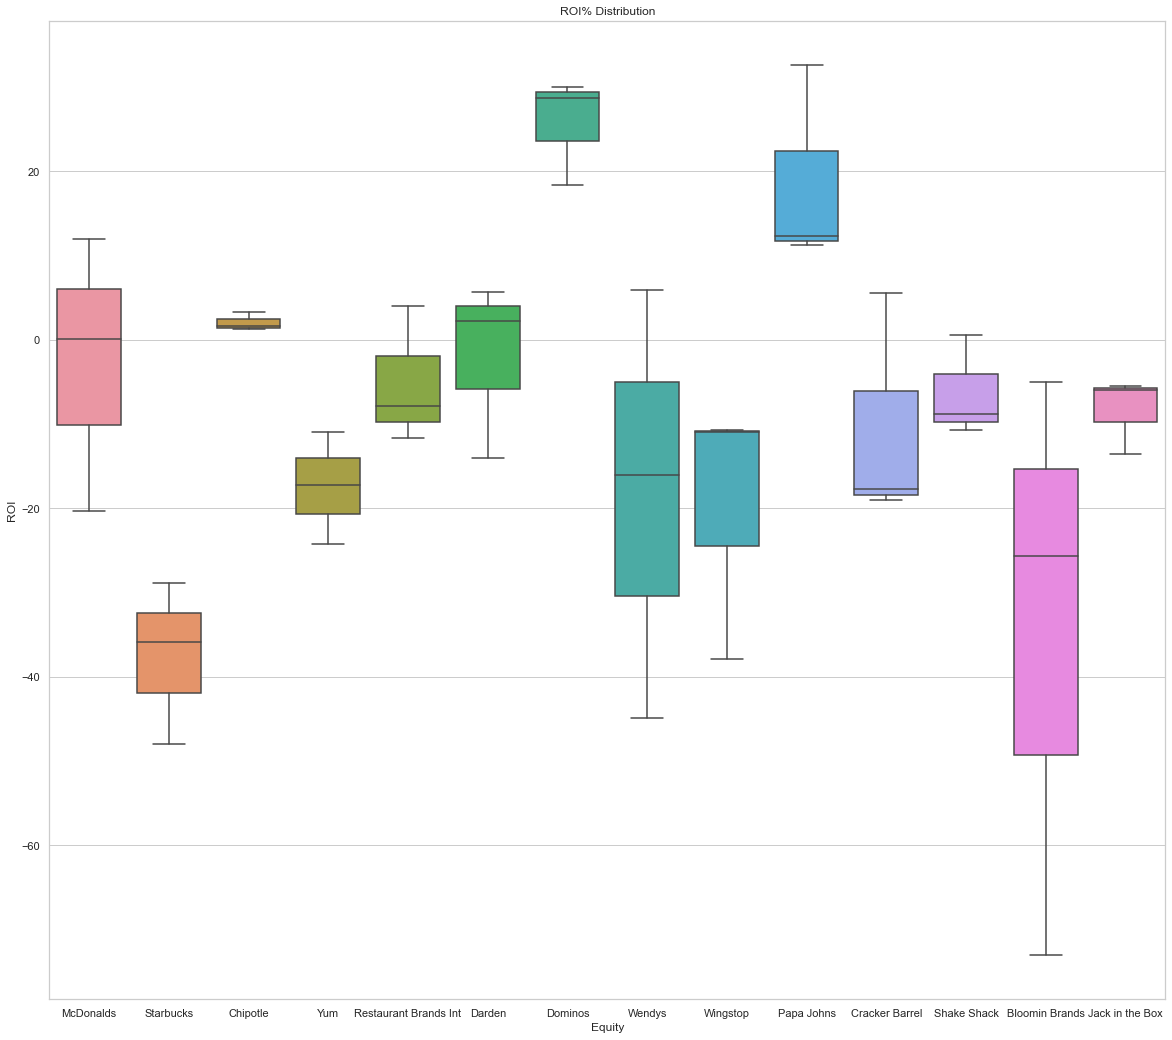

In [77]:
fig, ax = plt.subplots(figsize=(20, 18))
sns.boxplot(data=equity_rois_per, x='Equity', y='ROI')
ax.set_title('ROI% Distribution')
plt.show()

In [78]:
f, ax = plt.subplots(figsize=(6, 9))
sns.barplot(x='Average ROI',y='Equity', data=roi_means, color="green");

Ok, Now, I will make out of sample predictions on the LSTM since it performed the best except for a few outliers.

### TOP 3 PERFORMERS

**The top 3 performers were Dominos, Papa Johns, and Chipotle.**



### BOTTOM 3 PERFORMERS

**Here are the bottom 3 performers: Wingstop, Cracker Barrel, and Jack in the Box.**


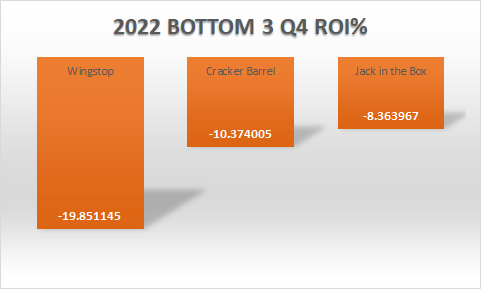

# CONCLUSION

**The top 3 were Dominos, Papa Johns, and Chipotle while the bottom 3 were Wingstop, Cracker Barrel, and Jack in the Box  .** The model’s results will help investors hoping for insight into the restaurant industry’s Q4 performance. Especially important in this model is its incorporation of COVID-19 death numbers. Thankfully, my prediction for COVID deaths are probably too high but there are no available datasets available that make better predictions at the same 2.5 month interval. In fact, most predictions only predict for 4 weeks and not on individual days. 

This notebook is a very fruitful start for modeling stock prices. However, some of its assumption could justifiably be questioned. The temporal link between COVID deaths and stock prices is real but the exact amount of time is not entirely clear. In fact, there is good evidence that it is actually much longer than I assume here. Moreover, there is good evidence that in-person dining actually effects COVID rates so these 2 variables could very well be in a feedback loop:

https://journals.lww.com/epidem/fulltext/2022/03000/the_impact_of_keeping_indoor_dining_closed_on.7.aspx

More exogenous variables like real estate prices, commodities prices, inflation rate and interest rates would certainly enhance this dataset and its analysis.

Overall, the model provides a great beginning for modeling stock prices.
